### Problem Statement
Predict whether a borrower will repay their loan on time based on various features such as loan amount, interest rate, borrower credit history, and other relevant factors.

### Data Description

In [1]:
# Data description
import pandas as pd
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,id,Identifier,integer,A unique identifier for each loan.
1,annual_income,Feature,float,The borrowers annual income (USD).
2,debt_to_income_ratio,Feature,float,"The Debt-to-Income ratio, indicating the borrowers debt compared to their income."
3,credit_score,Feature,integer,"The credit score of the borrower, indicating their creditworthiness."
4,loan_amount,Feature,float,The amount of money being borrowed (USD).
5,interest_rate,Feature,float,The interest rate for the loan ( %).
6,gender,Feature,object,"The gender of bowwer (Female, Male, Other)"
7,marital_status,Feature,object,"The marital status of the borrower (Single, Married, Divorced, Widowed)."
8,education_level,Feature,object,"The highest level of education attained by the borrower (High School, Master's, Bachelo'rs, PhD, Other)"
9,employment_status,Feature,object,"The type of employment status of the borrower (Self-employed, Employed, Unemployed, Retired, Student)"


### Load the dataset

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew
from scipy.stats import mannwhitneyu
from scipy.stats import uniform, randint, loguniform
# Explainability library
import shap
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
# Logistic Regression model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, roc_auc_score, f1_score, accuracy_score
# Random Forest model
from sklearn.ensemble import RandomForestClassifier
# XGBoost model
from xgboost import XGBClassifier
# LightGBM model
import lightgbm as lgb
from lightgbm import LGBMClassifier
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)
# CatBoost model
from catboost import CatBoostClassifier
# Neural Networks
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
# Suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Load the training data
df_train = pd.read_csv('train.csv')
print("Training data shape:", df_train.shape)
df_train.head()

Training data shape: (593994, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
# Load the test data
df_test = pd.read_csv('test.csv')
print("Test data shape:", df_test.shape)
df_test.head()

Test data shape: (254569, 12)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


### Understanding the Data

In [5]:
# Data overview
print(f'Data info on training data: {df_train.info()}\n')
print(f'Data info on test data: {df_test.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
Data info on training data: None

<class 'pand

In [6]:
# Check Null Values
df_train.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [7]:
# Check zero values
print(f'Zero values in training data:\n{df_train.isin([0]).sum()}\n')
print(f'Zero values in test data:\n{df_test.isin([0]).sum()}')


Zero values in training data:
id                           1
annual_income                0
debt_to_income_ratio         0
credit_score                 0
loan_amount                  0
interest_rate                0
gender                       0
marital_status               0
education_level              0
employment_status            0
loan_purpose                 0
grade_subgrade               0
loan_paid_back          119500
dtype: int64

Zero values in test data:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64


In [8]:
# Check negative values
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('loan_paid_back')
print(f'Negative values in training data:\n{(df_train[numerical_cols] < 0).sum()}\n')
print(f'Negative values in test data:\n{(df_test[numerical_cols] < 0).sum()}')

Negative values in training data:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
dtype: int64

Negative values in test data:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
dtype: int64


### Explore, Clean, Validate, and Visualize the Data

In [9]:
# Change data types for loan_paid_back
df_train['loan_paid_back'] = df_train['loan_paid_back'].astype('int')

In [10]:
# Drop ID column in training data
df_train.drop('id', axis=1, inplace=True)

loan_paid_back
1    474494
0    119500
Name: count, dtype: int64
Paid back ratio: 79.88%


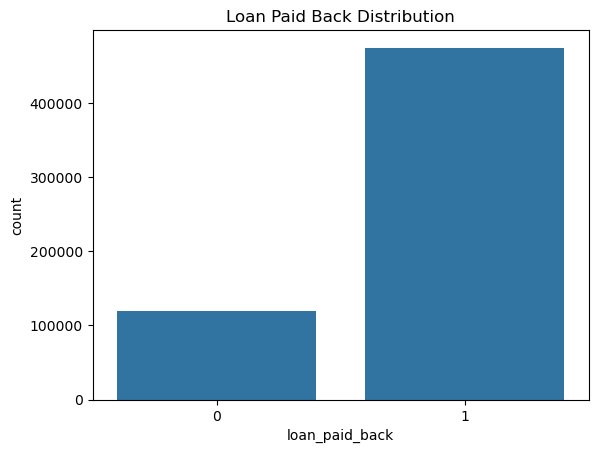

In [11]:
# Check loan_paid_back distribution
print(df_train['loan_paid_back'].value_counts())
# Paid back ratio
paid_back_ratio = df_train['loan_paid_back'].mean()
print(f'Paid back ratio: {paid_back_ratio:.2%}')
# Visualize loan_paid_back distribution

sns.countplot(x='loan_paid_back', data=df_train)
plt.title('Loan Paid Back Distribution')
plt.show()

In [12]:
# Split the data into training and validation sets
X = df_train.drop('loan_paid_back', axis=1)
y = df_train['loan_paid_back']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Paid back ratio in training set: {:.2%}".format(y_train.mean()))
print("Paid back ratio in validation set: {:.2%}".format(y_val.mean()))

Training set shape: (475195, 11) (475195,)
Validation set shape: (118799, 11) (118799,)
Paid back ratio in training set: 79.88%
Paid back ratio in validation set: 79.88%


In [13]:
# Separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


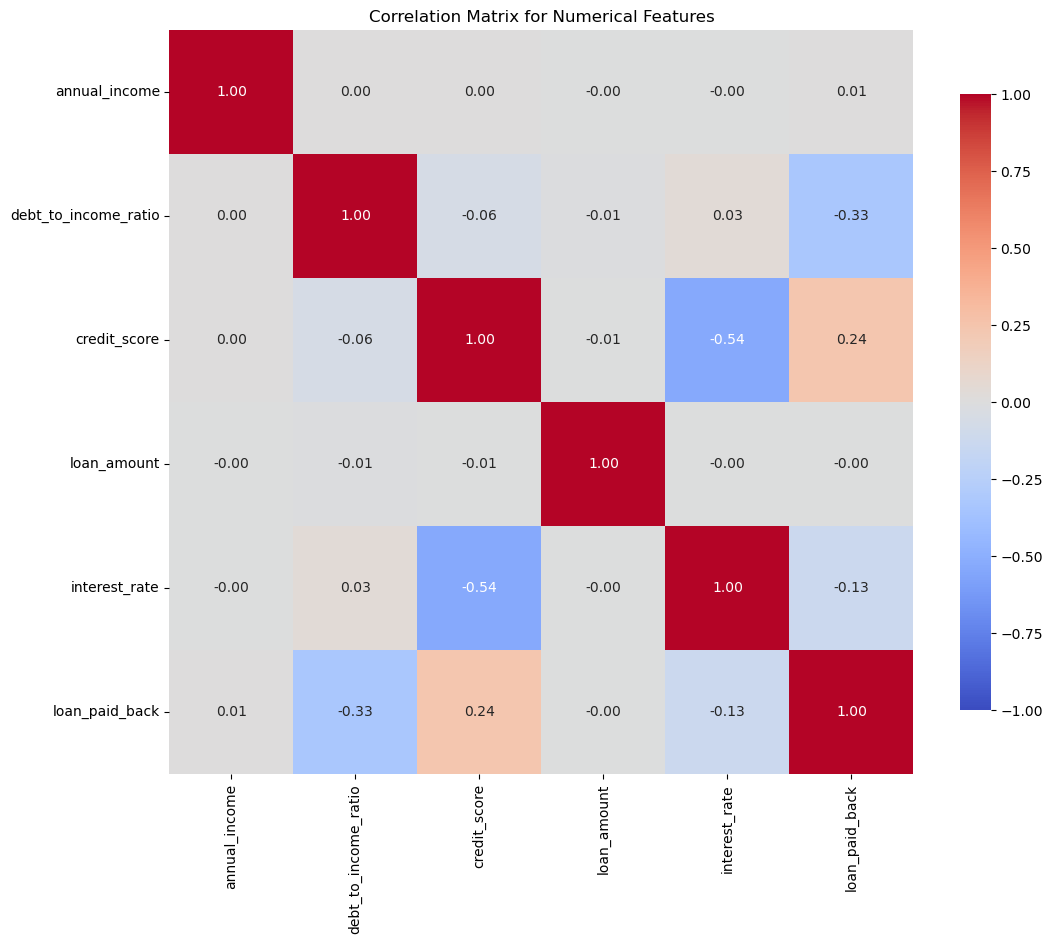

In [14]:
# Combine X_train and y_train for easier processing
Xy_train = pd.concat([X_train, y_train], axis=1)
# Correlation matrix for numerical features
plt.figure(figsize=(12, 10))
corr_matrix = Xy_train[numerical_cols + ['loan_paid_back']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmax=1.0, vmin=-1.0, center=0)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

Heatmap of Correlation Matrix shows
- interest_rate vs credit_score: -0.54 (negative correlation) that means as credit score increases, interest rate decreases. The higher the credit score, the lower the risk for lenders, leading to lower interest rates.
- loan_paid_back vs credit_score: +0.24 (positive correlation) that means as credit score increases, the likelihood of loan being paid back increases. Borrowers with higher credit scores are generally more reliable in repaying their loans.
- loan_paid_back vs debt_to_income_ratio: -0.33 (negative correlation) that means as debt-to-income ratio increases, the likelihood of loan being paid back decreases. A higher debt-to-income ratio indicates that a borrower has a larger portion of their income going towards debt payments, which can make it more challenging to repay additional loans.

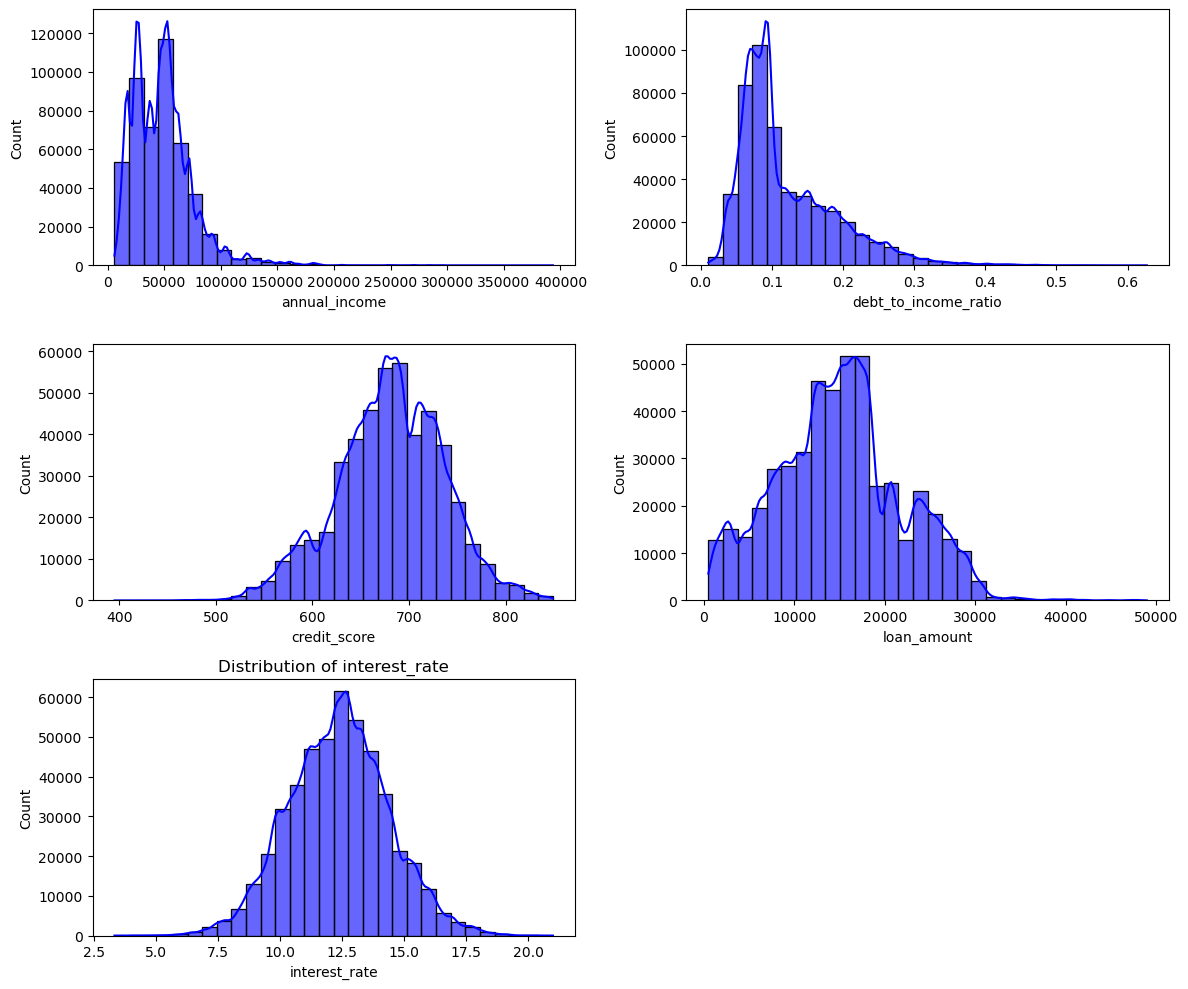

In [15]:
# Plot all the numerical columns of X_train to understand their distribution
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(X_train[col], bins=30, kde=True, color='blue', alpha=0.6)
plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [16]:
# Calculate skewness for numerical features
skewed_features = X_train[numerical_cols].apply(lambda x: skew(x.dropna()))
print("Skewness of numerical features:\n", skewed_features)

Skewness of numerical features:
 annual_income           1.711930
debt_to_income_ratio    1.405213
credit_score           -0.167373
loan_amount             0.205164
interest_rate           0.048988
dtype: float64


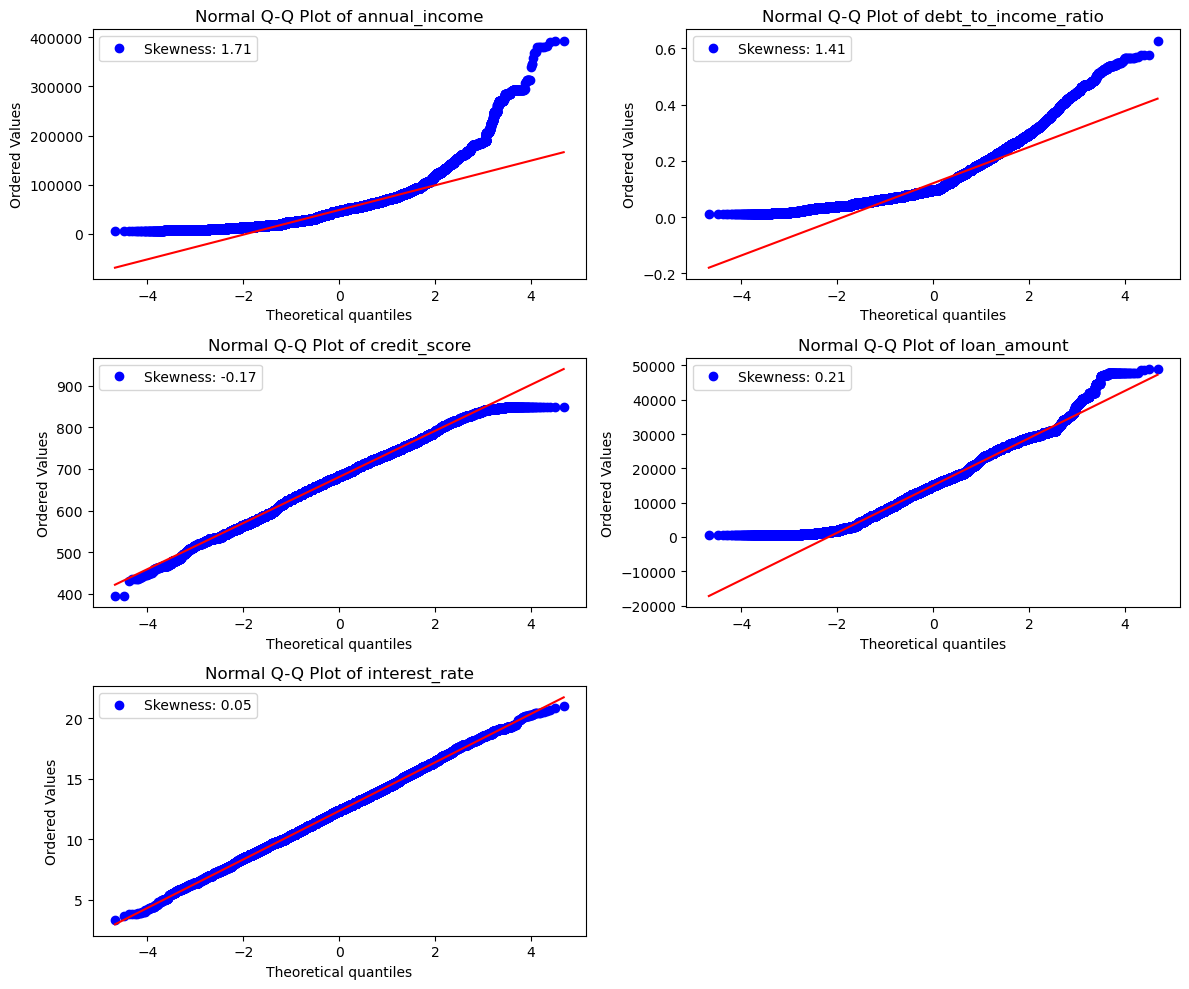

In [17]:
# Plot all the categorical columns of X_train to understand their distribution
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    stats.probplot(X_train[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Normal Q-Q Plot of {col}')
    plt.legend([f'Skewness: {skew(X_train[col]):.2f}'])
plt.tight_layout()
plt.show()

- Skew value > 1 or < -1 indicates a highly skewed distribution.
- Skew value between 0.5 and 1 or -0.5 and -1 indicates a moderately skewed distribution.
- Skew value between -0.5 and 0.5 indicates a approximately symmetric distribution.
- A positive skew indicates a longer right tail, while a negative skew indicates a longer left tail.

Based on the skewness values:
- annual_income has a high positive skew at 1.71 indicating a longer right tail
- debt_to_income_ratio has a high positive skew at 1.41 indicating a longer right tail
- credit_score has a moderate negative skew at -0.17 indicating a longer left tail
- loan_amount has a moderate positive skew at 0.21 indicating a longer right tail
- interest_rate has a low positive skew at 0.05 indicating a longer right tail

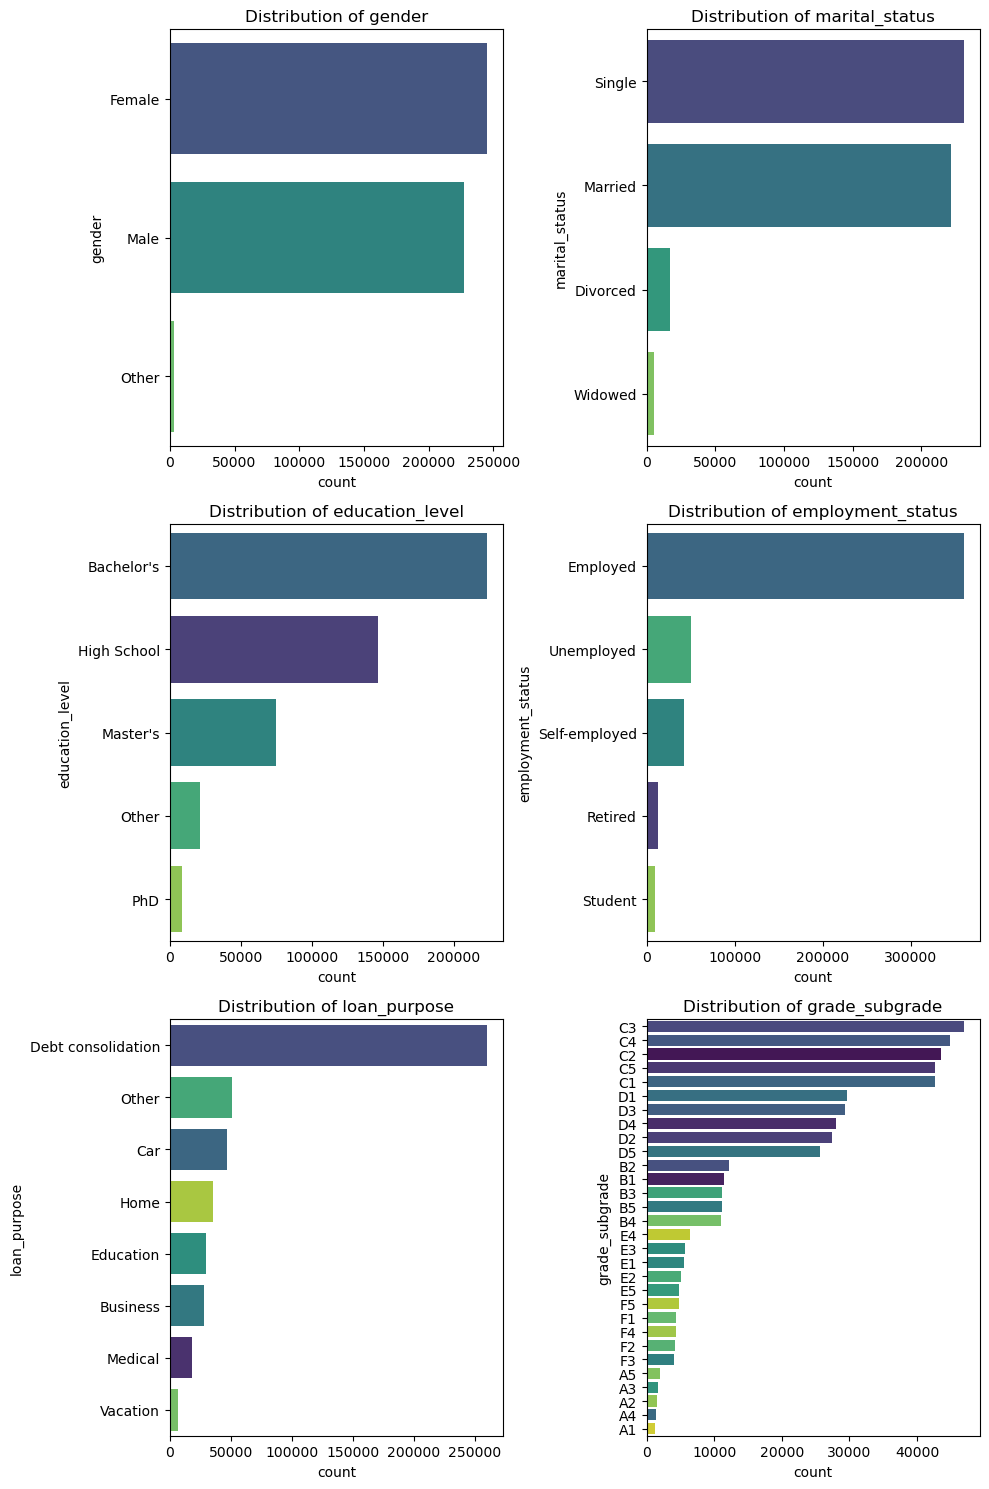

In [18]:
# Plot all the categorical columns of X_train to understand their distribution
plt.figure(figsize=(10, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=X_train[col], order=X_train[col].value_counts().index, palette='viridis', hue=X_train[col], legend=False)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

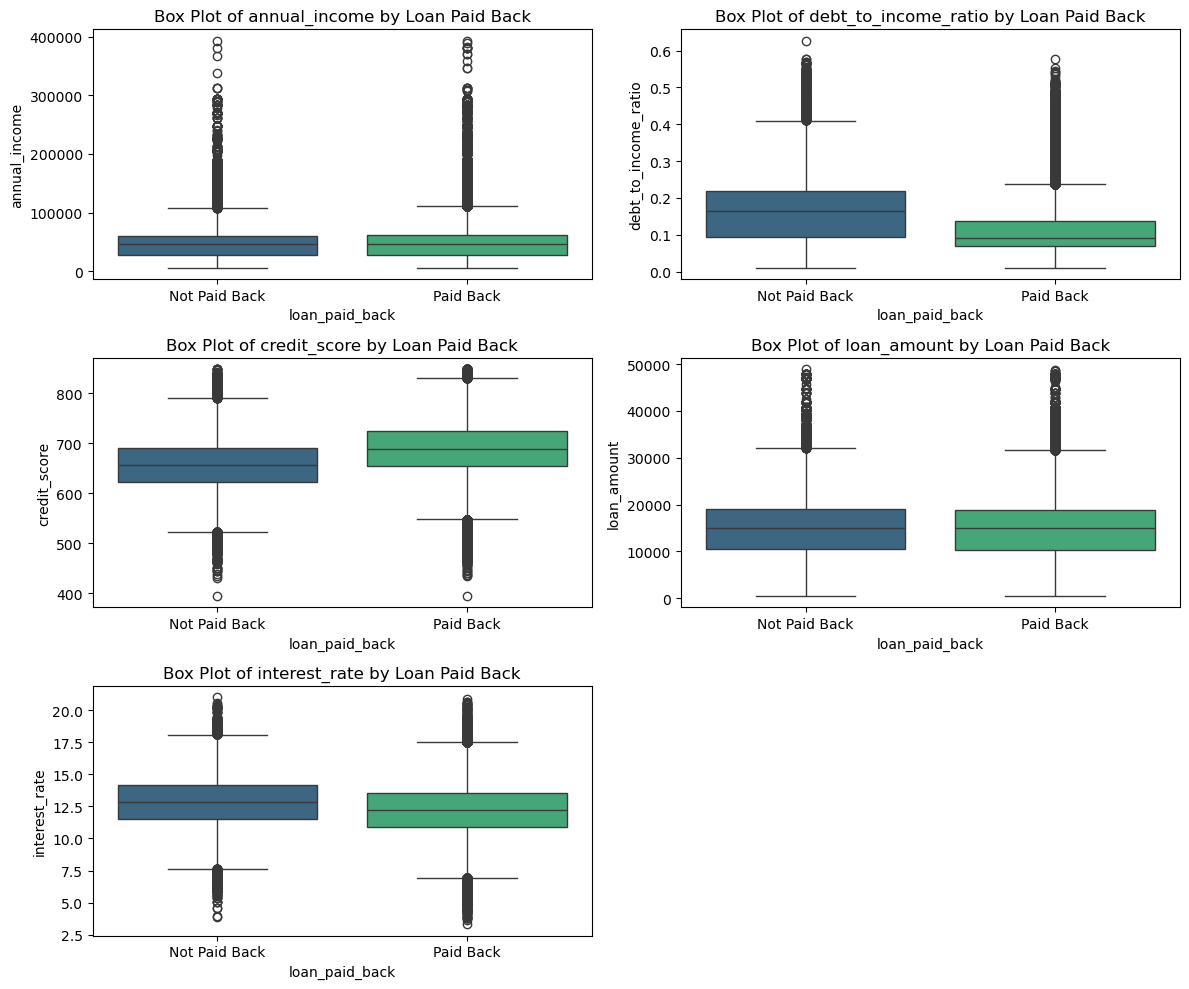

                 count          mean    median           std
loan_paid_back                                              
1               379595  48286.101153  46667.37  26546.698189
0                95600  47814.988660  45933.39  27005.530715
Z-Test for annual_income: statistic=4.8373, p-value=0.0000
  -> Significant difference in annual_income between paid back and not paid back groups.

                 count      mean  median       std
loan_paid_back                                    
0                95600  0.166344   0.165  0.083079
1               379595  0.109145   0.092  0.058968
Z-Test for debt_to_income_ratio: statistic=-200.5305, p-value=0.0000
  -> Significant difference in debt_to_income_ratio between paid back and not paid back groups.

                 count        mean  median        std
loan_paid_back                                       
1               379595  687.539291   688.0  54.419285
0                95600  654.982479   657.0  51.702640
Z-Test for credit_sco

In [19]:
# Visualise the relationship between numerical features and the target variable to understand their impact on the target outcome
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=Xy_train['loan_paid_back'], y=Xy_train[col], palette='viridis', hue=Xy_train['loan_paid_back'], legend=False)
    plt.title(f'Box Plot of {col} by Loan Paid Back')
    plt.xticks([0, 1], ['Not Paid Back', 'Paid Back'])
plt.tight_layout()
plt.show()
# Z-Test for numerical features between paid back and not paid back groups
for col in numerical_cols:
    print(Xy_train.groupby('loan_paid_back')[col].agg(['count', 'mean', 'median', 'std']).sort_values(by = 'mean', ascending = False))
    group1 = Xy_train[Xy_train['loan_paid_back'] == 1][col].dropna()
    group0 = Xy_train[Xy_train['loan_paid_back'] == 0][col].dropna()
    stat, p = stats.ttest_ind(group1, group0, equal_var=False)
    print(f'Z-Test for {col}: statistic={stat:.4f}, p-value={p:.4f}')
    if p < 0.05:
        print(f'  -> Significant difference in {col} between paid back and not paid back groups.\n')
    else:
        print(f'  -> No significant difference in {col} between paid back and not paid back groups.\n')
    

Numerical likelihood and statistical analysis:
  - annual_income: Borrowers who paid back their loans tend to have a higher annual income. Statistical tests = 4.8373, p-value = 0.0000 indicate a significant difference.
  - debt_to_income_ratio: Borrowers who paid back their loans have a lower debt-to-income ratio. Statistical tests = -200.5305, p-value = 0.0000 indicate a significant difference.
  - credit_score: Borrowers who paid back their loans have a higher credit score. Statistical tests = 172.1557, p-value = 0.0000 indicate a significant difference.
  - loan_amount: There is a slight difference in loan amounts between the two groups, with those who paid back having a marginally lower average loan amount. Statistical tests = -3.0178, p-value = 0.0025 indicate a significant difference.
  - interest_rate: Borrowers who paid back their loans tend to have lower interest rates. Statistical tests = -91.8469, p-value = 0.0000 indicate a significant difference.
  - Overall, borrowers with higher income, lower debt-to-income ratios, higher credit scores, slightly lower loan amounts, and lower interest rates are more likely to repay their loans on time.
  - Top predictive features for loan repayment:
    - annual_income (4.8373) - higher income indicates higher likelihood of repayment (strong predictor)
    - debt_to_income_ratio (-200.5305) - higher ratio indicates lower likelihood of repayment (strong predictor)
    - credit_score (172.1557) - higher score indicates higher likelihood of repayment (strong predictor)
    - interest_rate (-91.8469) - lower rate indicates higher likelihood of repayment (strong predictor)
    - loan_amount (-3.0178) - lower amount indicates higher likelihood of repayment (weak predictor)

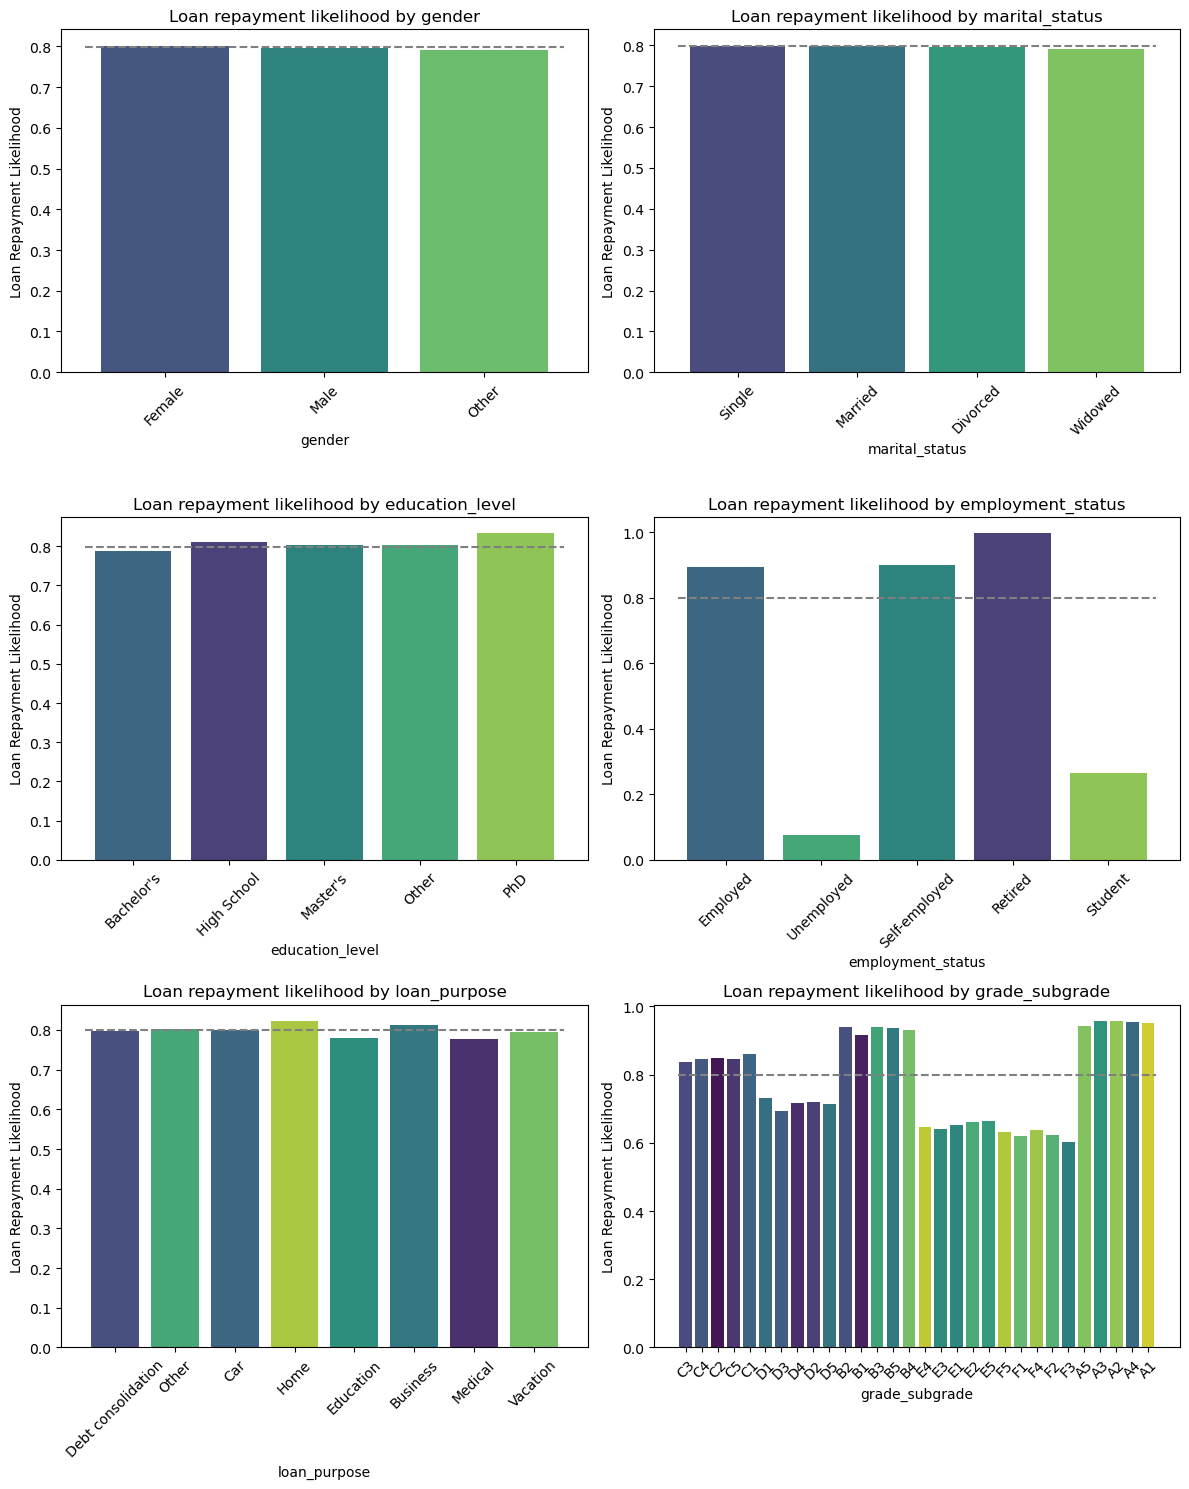

         count      mean       std
gender                            
Female  245125  0.801836  0.398617
Male    227097  0.795656  0.403223
Other     2973  0.791793  0.406094
gender: Chi2=28.93621186765137, p-value=5.206926284772197e-07
  -> Significant association between gender and Default (p < 0.05)

                 count      mean       std
marital_status                            
Married         221925  0.799477  0.400392
Single          230927  0.798573  0.401067
Divorced         17099  0.795894  0.403058
Widowed           5244  0.791381  0.406360
marital_status: Chi2=3.401045196738883, p-value=0.33382481684277077
  -> No significant association between marital_status and Default (p >= 0.05)

                  count      mean       std
education_level                            
PhD                8788  0.832840  0.373140
High School      146967  0.809828  0.392438
Master's          74536  0.802364  0.398219
Other             21354  0.802238  0.398321
Bachelor's       223550  

In [20]:
# Visualise the relationship between categorical features and the target variable to understand their impact on the target outcome
plt.figure(figsize=(12, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    # order categories by frequency (you can change to order by mean repayment if preferred)
    order = Xy_train[col].value_counts().index
    sns.barplot(x=Xy_train[col], y=Xy_train['loan_paid_back'], palette='viridis', hue=Xy_train[col], legend=False, errorbar=None, order=order)
    plt.title(f'Loan repayment likelihood by {col}')
    plt.xlabel(col)
    plt.ylabel('Loan Repayment Likelihood')
    plt.hlines(y=Xy_train['loan_paid_back'].mean(), xmin=-0.5, xmax=len(order)-0.5, color='gray', linestyle='--')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chi-Squared Test for categorical features against the target variable
from scipy.stats import chi2_contingency
for col in categorical_cols:
    print(Xy_train.groupby(col)['loan_paid_back'].agg(['count', 'mean', 'std']).sort_values(by='mean', ascending=False))
    contingency_table = pd.crosstab(Xy_train[col], Xy_train['loan_paid_back'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'{col}: Chi2={chi2}, p-value={p}')
    if p < 0.05:
        print(f'  -> Significant association between {col} and Default (p < 0.05)\n')
    else:
        print(f'  -> No significant association between {col} and Default (p >= 0.05)\n')

Categorical likelihood and statistical analysis:
- Gender: Chi2=28.93621186765137, p-value=5.206926284772197e-07
  -> Significant association between gender and Default (p < 0.05), but the effect size is small. Female borrowers have a slightly higher repayment rate (80.18%) compared to male borrowers (79.57%).
- Marital Status: Chi2=3.401045196738883, p-value=0.33382481684277077
  -> No significant association between marital_status and Default (p >= 0.05). All marital status categories have similar repayment rates around 79-80%.
- Education Level: Chi2=322.92668361461745, p-value=1.2249461743547264e-68
  -> Significant association between education_level and Default (p < 0.05), the effect size is moderate. Borrowers with higher education levels (PhD: 83.28%, High School: 80.98%) tend to have higher repayment rates compared to those with Bachelor's degrees (78.87%).
- Employment Status: Chi2=205755.39520758076, p-value=0.0
  -> Significant association between employment_status and Default (p < 0.05), the effect size is large. Retired borrowers have the highest repayment rate (99.74%), followed by self-employed (89.93%) and employed (89.44%). Students (26.43%) and unemployed (7.72%) have much lower repayment rates.
- Loan Purpose: Chi2=300.4652366488024, p-value=4.812558369860348e-61
  -> Significant association between loan_purpose and Default (p < 0.05), the effect size is moderate. Loans for Home (82.27%) and Business (81.29%) purposes have higher repayment rates compared to Education (77.87%) and Medical (77.71%).
- Grade Subgrade: Chi2=24902.85660786064, p-value=0.0
  -> Significant association between grade_subgrade and Default (p < 0.05), the effect size is large. Higher grade subgrades (A1: 95.23%, A2: 95.72%) have much higher repayment rates compared to lower grades (F3: 60.18%, F1: 62.00%).

In [21]:
# Drop very weakly impactful features based on statistical tests
weak_impact_features = ['marital_status']
X_train.drop(columns=weak_impact_features, inplace=True)
X_val.drop(columns=weak_impact_features, inplace=True)

### Feature Engineering

In [22]:
# Rank grade_subgrade by mapping letters to numbers
grade_mapping = {grade: idx for idx, grade in enumerate(sorted(X_train['grade_subgrade'].unique()), 1)}
print("Grade mapping:", grade_mapping)
# Map the grades to numerical values
X_train['grade_subgrade_num'] = X_train['grade_subgrade'].map(grade_mapping)
X_val['grade_subgrade_num'] = X_val['grade_subgrade'].map(grade_mapping)


Grade mapping: {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20, 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25, 'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30}


In [23]:
# Subcategory encoding for grade_subgrade
def mapping_grade_subgrade(grade):
    if grade.startswith('A'):
        return 'very_low_risk'
    elif grade.startswith('B'):
        return 'low_risk'
    elif grade.startswith('C'):
        return 'moderate_risk'
    elif grade.startswith('D'):
        return 'high_risk'
    elif grade.startswith('E'):
        return 'very_high_risk'
    else:
        return 'extreme_risk'
X_train['grade_risk_category'] = X_train['grade_subgrade'].apply(mapping_grade_subgrade).astype('category')
X_val['grade_risk_category'] = X_val['grade_subgrade'].apply(mapping_grade_subgrade).astype('category')
# Drop original grade_subgrade column
X_train.drop(columns=['grade_subgrade'], inplace=True)
X_val.drop(columns=['grade_subgrade'], inplace=True)

In [24]:
# Define a function feature_engineering to preprocess the data
def feature_engineering(X):
    X_processed = X.copy()
    
    # 1. Interest Burden Ratio
    X_processed['interest_burden_ratio'] = (X_processed['loan_amount'] * X_processed['interest_rate']) / X_processed['annual_income']
    # 2. Credit Risk Score with respect to loan amount
    X_processed['credit_risk_score'] = X_processed['credit_score'] / X_processed['loan_amount']
    # 3. Measure of financial stress
    X_processed['financial_stress_index'] = X_processed['loan_amount'] * X_processed['debt_to_income_ratio'] / (X_processed['annual_income'])
    # 4. Financial stress score
    X_processed['financial_stress_score'] = X_processed['loan_amount'] / (X_processed['annual_income'] * (1 - X_processed['debt_to_income_ratio'])).clip(lower=1e-5)
    # 5. Loan Burden Score
    X_processed['loan_burden_score'] = X_processed['debt_to_income_ratio'] * X_processed['interest_rate']
    # 6. Credit Risk Score with respect to loan amount
    X_processed['credit_risk_score'] = X_processed['credit_score'] / X_processed['loan_amount']
    # 7. Credit Score to Debt-to-Income Ratio
    X_processed['credit_to_dti_ratio'] = X_processed['credit_score'] / (X_processed['debt_to_income_ratio'] + 1e-5)
    # 8. Loan Affordability Index
    X_processed['loan_affordability_index'] = X_processed['annual_income'] / X_processed['loan_amount']
    # 9. Low credit score flag
    X_processed['low_credit_score_flag'] = (X_processed['credit_score'] < 600).astype(int)
    # 10. High debt-to-income ratio flag
    X_processed['high_dti_flag'] = (X_processed['debt_to_income_ratio'] > X_train['debt_to_income_ratio'].median()).astype(int)
    # 11. Safe Index
    X_processed['safe_index'] = (X_processed['credit_score'] / 850) * (1 - X_processed['debt_to_income_ratio']) * (1 - X_processed['interest_rate'] / 100)
    # 12. Normalize credit score
    X_processed['normalized_credit_score'] = (X_processed['credit_score'] - X_processed['credit_score'].mean()) / np.std(X_processed['credit_score'])
    # 13. High interest burden flag
    X_processed['high_interest_burden_flag'] = (X_processed['interest_burden_ratio'] > 0.3).astype(int)
    return X_processed

In [25]:
# Apply feature engineering to training and validation sets
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

In [26]:
# Categorical variables
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns after feature engineering:", categorical_cols)

Categorical columns after feature engineering: ['gender', 'education_level', 'employment_status', 'loan_purpose', 'grade_risk_category']


Categorical columns after feature engineering: ['education_level', 'employment_status', 'loan_purpose', 'grade_risk_category']

In [27]:
# Encode categorical variables using one-hot encoding
X_train_encoded = pd.get_dummies(X_train, dtype=int)
X_train_encoded = X_train_encoded.rename(columns=lambda x: x.replace(' ', '_'))
X_val_encoded = pd.get_dummies(X_val, dtype=int)
X_val_encoded = X_val_encoded.rename(columns=lambda x: x.replace(' ', '_'))
print("Encoded training set shape:", X_train_encoded.shape)
print("Encoded validation set shape:", X_val_encoded.shape)
# Align the columns of the validation set with the training set
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

Encoded training set shape: (475195, 45)
Encoded validation set shape: (118799, 45)


### Model Building and Evaluation

#### 1. Logistic Regression Model

In [28]:
# Preparing the data for modeling
X_train_logistic = X_train_encoded.copy()
X_val_logistic = X_val_encoded.copy()

In [29]:
# Log-transform highly skewed numerical features
numerical_cols_update = X_train_logistic.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Compute skewness for those numeric columns
skewed_features = X_train_logistic[numerical_cols_update].apply(lambda x: skew(x.dropna()))
skewed_cols = skewed_features[skewed_features.abs() > 1].index.tolist()
print("Highly skewed columns to be log-transformed:", skewed_cols)
for col in skewed_cols:
    X_train_logistic[col] = np.log1p(X_train_logistic[col])
    X_val_logistic[col] = np.log1p(X_val_logistic[col])

Highly skewed columns to be log-transformed: ['annual_income', 'debt_to_income_ratio', 'interest_burden_ratio', 'credit_risk_score', 'financial_stress_index', 'financial_stress_score', 'loan_burden_score', 'credit_to_dti_ratio', 'loan_affordability_index']


In [30]:
# Scale numerical features
cols_to_scale = X_train_logistic.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train_logistic[cols_to_scale] = scaler.fit_transform(X_train_logistic[cols_to_scale])
X_val_logistic[cols_to_scale] = scaler.transform(X_val_logistic[cols_to_scale])

In [31]:
X_train_logistic

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,grade_subgrade_num,interest_burden_ratio,credit_risk_score,financial_stress_index,financial_stress_score,...,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation,grade_risk_category_extreme_risk,grade_risk_category_high_risk,grade_risk_category_low_risk,grade_risk_category_moderate_risk,grade_risk_category_very_high_risk,grade_risk_category_very_low_risk
236143,-1.657979,-0.534356,0.288781,1.539025,0.311546,-0.578860,2.252369,-0.511243,1.446633,2.641564,...,0,1,0,0,0,0,0,1,0,0
49950,0.529512,-1.026924,2.074439,0.543904,-1.048312,-1.751494,-0.216626,-0.322149,-0.605909,-0.267291,...,0,0,0,0,0,0,1,0,0,0
352634,0.816728,1.063733,-0.306439,-0.267635,-1.277446,0.789212,-0.855743,-0.223031,-0.219102,-0.613212,...,0,0,0,0,0,1,0,0,0,0
410550,-0.957272,0.703590,0.938111,-0.418989,-1.775563,0.007457,0.083905,-0.100551,0.593695,0.424501,...,0,0,0,0,0,0,0,1,0,0
341949,-0.685260,0.335641,-0.306439,0.238722,-0.415704,0.398334,0.666050,-0.353526,0.599405,0.650086,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15783,-0.952281,-0.707507,0.811852,-1.291266,-1.177823,-0.187982,-0.599360,0.596157,-0.599107,-0.544234,...,0,0,0,0,0,0,0,1,0,0
577584,0.065494,-0.393989,-0.089995,-0.060700,-0.709593,-0.774299,-0.128409,-0.273679,-0.346804,-0.210559,...,0,0,0,1,0,0,0,1,0,0
355758,0.407895,1.541580,-1.226323,0.326247,0.092374,0.789212,0.015187,-0.407375,0.445300,-0.049535,...,0,0,1,0,0,1,0,0,0,0
590862,0.972361,1.486056,0.667557,1.348654,0.535698,-0.774299,0.138473,-0.482117,0.458403,-0.021034,...,0,0,0,0,0,0,0,1,0,0


In [32]:
# Using statsmodels for Logistic Regression
# Add constant and fit the logistic regression model
X_train_sm_1 = sm.add_constant(X_train_logistic)
# Logistic regression model
logit_model_1 = sm.Logit(y_train, X_train_sm_1)
# Fit the model
result = logit_model_1.fit(disp=False, maxiter=100)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:         loan_paid_back   No. Observations:               475195
Model:                          Logit   Df Residuals:                   475155
Method:                           MLE   Df Model:                           39
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.4853
Time:                        00:11:54   Log-Likelihood:            -1.2280e+05
converged:                       True   LL-Null:                   -2.3856e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.9526        nan        nan        nan         nan         nan
annual_income                         -0.0164      0.036   

In [33]:
# VIF Calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
X_train_vif_1 = X_train_sm_1.drop(columns=['const'])
vif_data["feature"] = X_train_vif_1.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif_1.values, i) for i in range(X_train_vif_1.shape[1])]
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
20,gender_Other,9.228215e+10
38,loan_purpose_Vacation,3.350618e+10
29,employment_status_Student,2.539285e+10
25,education_level_PhD,1.817375e+10
35,loan_purpose_Home,1.156433e+10
43,grade_risk_category_very_high_risk,4.686922e+09
32,loan_purpose_Car,9.628319e+08
24,education_level_Other,5.807922e+07
37,loan_purpose_Other,2.175245e+07
39,grade_risk_category_extreme_risk,1.936039e+07


In [34]:
# Reduce multicollinearity by dropping features with high VIF
X_train_sm_2 = X_train_sm_1.drop(columns=[
    "const", "gender_Other", "education_level_Bachelor's", "employment_status_Unemployed",
    "loan_purpose_Medical", "grade_risk_category_very_high_risk", "credit_score", 
    "debt_to_income_ratio", "interest_rate","gender_Male",
    "loan_amount", "annual_income", "financial_stress_index",
    "interest_burden_ratio", "low_credit_score_flag", "education_level_Other",
    "high_interest_burden_flag", "loan_purpose_Education", "grade_risk_category_low_risk",
    "financial_stress_score", "normalized_credit_score", "credit_risk_score",
    "loan_burden_score", "grade_risk_category_very_low_risk", "credit_to_dti_ratio",
    "employment_status_Employed"
])
# Refit the model
X_train_sm_2 = sm.add_constant(X_train_sm_2)
logit_model_2 = sm.Logit(y_train, X_train_sm_2)
result2 = logit_model_2.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.404528
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:         loan_paid_back   No. Observations:               475195
Model:                          Logit   Df Residuals:                   475174
Method:                           MLE   Df Model:                           20
Date:                Fri, 14 Nov 2025   Pseudo R-squ.:                  0.1942
Time:                        00:22:18   Log-Likelihood:            -1.9223e+05
converged:                       True   LL-Null:                   -2.3856e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.7305      0.018     9

In [35]:
# Calculate VIF for each feature
X_train_vif = X_train_sm_2.drop(columns=['const'])
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
# Display VIF results
print(vif_data.sort_values(by="VIF", ascending=False))

                              feature       VIF
13    loan_purpose_Debt_consolidation  3.598237
0                  grade_subgrade_num  3.568491
3                          safe_index  3.222537
2                       high_dti_flag  2.980226
19  grade_risk_category_moderate_risk  2.658188
18      grade_risk_category_high_risk  2.651862
17   grade_risk_category_extreme_risk  1.996173
4                       gender_Female  1.947343
5         education_level_High_School  1.543327
15                 loan_purpose_Other  1.508401
12                   loan_purpose_Car  1.465527
14                  loan_purpose_Home  1.354955
11              loan_purpose_Business  1.283855
6            education_level_Master's  1.275074
9     employment_status_Self-employed  1.097032
16              loan_purpose_Vacation  1.067265
7                 education_level_PhD  1.033183
8           employment_status_Retired  1.031444
10          employment_status_Student  1.026664
1            loan_affordability_index  1

In [36]:
# Keep only columns present in VIF analysis
column_to_keep = X_train_vif.columns.tolist()
X_train_logistic_final = X_train_logistic[column_to_keep]
X_val_logistic_final = X_val_logistic[column_to_keep]
# Predict using the final logistic regression model
y_train_pred_lr = result2.predict(sm.add_constant(X_train_logistic_final))
y_val_pred_lr = result2.predict(sm.add_constant(X_val_logistic_final))
# ROC-AUC scores
train_roc_auc_lr = roc_auc_score(y_train, y_train_pred_lr)
val_roc_auc_lr = roc_auc_score(y_val, y_val_pred_lr)
print("Logistic Regression Model -  Train set ROC-AUC:", train_roc_auc_lr)
print("Logistic Regression Model -  Validation set ROC-AUC:", val_roc_auc_lr)

Logistic Regression Model -  Train set ROC-AUC: 0.794414656647106
Logistic Regression Model -  Validation set ROC-AUC: 0.7936635527196256


The logistic regression model shows a good performance with ROC-AUC scores of approximately 0.79 on both the training and validation sets, indicating that the model is effective at distinguishing between borrowers who will repay their loans and those who will not. The consistency between the training and validation scores suggests that the model generalizes well to unseen data without significant overfitting.

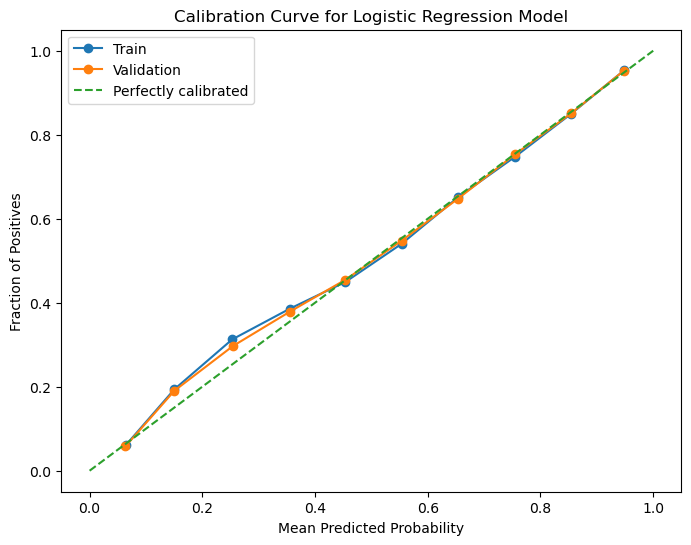

In [37]:
# Evaluate calibration curve
title = 'Calibration Curve for Logistic Regression Model'
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred_lr, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_pred_lr, n_bins=10) 
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Train')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='Validation')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title(title)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [38]:
# Quantify calibration using Brier Score
brier_score_train_lr = brier_score_loss(y_train, y_train_pred_lr)
brier_score_val_lr = brier_score_loss(y_val, y_val_pred_lr)
print(f"Logistic Brier Score for Logistic Regression - Train set: {brier_score_train_lr:.4f}")
print(f"Logistic Brier Score for Logistic Regression - Validation set: {brier_score_val_lr:.4f}")

Logistic Brier Score for Logistic Regression - Train set: 0.1284
Logistic Brier Score for Logistic Regression - Validation set: 0.1283


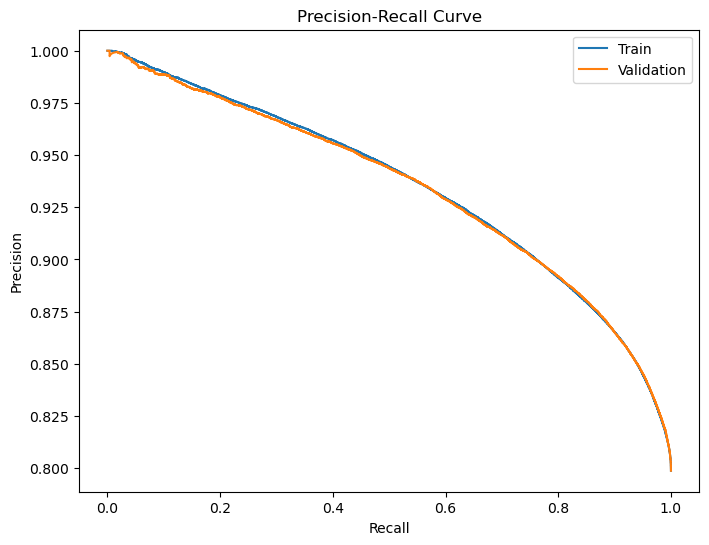

In [39]:
# Precision-Recall Curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_lr)
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred_lr)
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label='Train')
plt.plot(recall_val, precision_val, label='Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [40]:
# Average Precision Score (Area under Precision-Recall Curve)
average_precision_train_lr = average_precision_score(y_train, y_train_pred_lr)
average_precision_val_lr = average_precision_score(y_val, y_val_pred_lr)
print(f"Logistic Regression - Train set Average Precision Score: {average_precision_train_lr:.4f}")
print(f"Logistic Regression - Validation set Average Precision Score: {average_precision_val_lr:.4f}")

Logistic Regression - Train set Average Precision Score: 0.9349
Logistic Regression - Validation set Average Precision Score: 0.9341


Best threshold for Logistic Regression based on F1-score: 0.4418


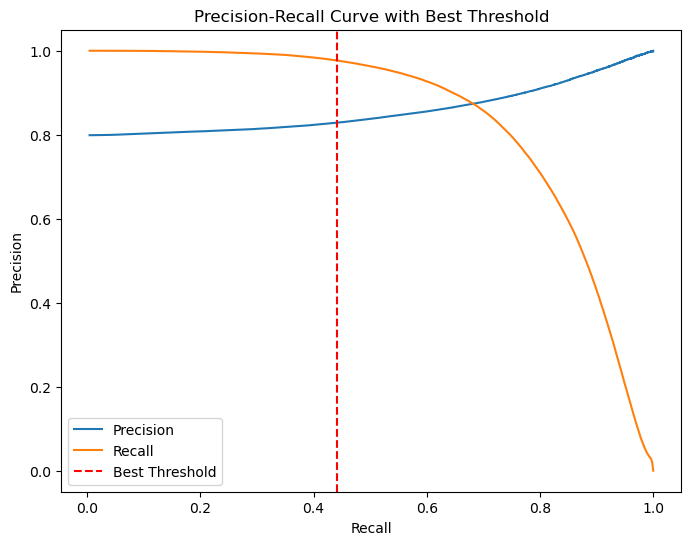

In [41]:
# Pick threshold based on business needs (maximizing F1-score)
f1_scores_logistic = 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-10)
best_threshold_index = np.argmax(f1_scores_logistic)
best_threshold_logistic = thresholds_val[best_threshold_index]
print(f"Best threshold for Logistic Regression based on F1-score: {best_threshold_logistic:.4f}")
# Plot Precision-Recall Curve with best threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_val, precision_val[:-1], label='Precision')
plt.plot(thresholds_val, recall_val[:-1], label='Recall')
plt.axvline(x=best_threshold_logistic, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold')
plt.legend()
plt.show()

In [42]:
# Evaluate model at the best threshold
y_train_pred_logistic = (y_train_pred_lr >= best_threshold_logistic).astype(int)
y_val_pred_logistic = (y_val_pred_lr >= best_threshold_logistic).astype(int)

print("Logistic Regression Model Evaluation at Best Threshold:")
print(f"Train Classification Report:\n{classification_report(y_train, y_train_pred_logistic)}")
print(f"Validation Classification Report:\n{classification_report(y_val, y_val_pred_logistic)}")


Logistic Regression Model Evaluation at Best Threshold:
Train Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.20      0.30     95600
           1       0.83      0.98      0.90    379595

    accuracy                           0.82    475195
   macro avg       0.75      0.59      0.60    475195
weighted avg       0.80      0.82      0.78    475195

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.20      0.31     23900
           1       0.83      0.98      0.90     94899

    accuracy                           0.82    118799
   macro avg       0.76      0.59      0.60    118799
weighted avg       0.80      0.82      0.78    118799



The confusion matrix and classification report indicate that while the model has high precision and recall for predicting loan repayment (class 1), it struggles with predicting non-repayment (class 0), as evidenced by the low recall of 0.20 for that class. This suggests that the model is more effective at identifying borrowers who will repay their loans than those who will default.
- The AUC-ROC score of approximately 0.79 indicates that the model has a good ability to distinguish between borrowers who will repay their loans and those who will not.
- The Brier Score values of around 0.129 suggest that the predicted probabilities are reasonably well-calibrated, with lower scores indicating better calibration.
- The Average Precision Score of approximately 0.93 indicates that the model performs well in terms of precision and recall, particularly for the positive class (loan repayment).

#### 2. Random Forest Model

In [43]:
X_train_tree = X_train_encoded.copy()
X_val_tree = X_val_encoded.copy()
print("X_train_tree shape:", X_train_tree.shape)
print("X_val_tree shape:", X_val_tree.shape)

X_train_tree shape: (475195, 45)
X_val_tree shape: (118799, 45)


In [44]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=100, n_jobs=-1)
rf_model.fit(X_train_tree, y_train)
# Predict probabilities
y_train_pred_prob_rf = rf_model.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_rf = rf_model.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_prob_rf)
val_roc_auc_rf = roc_auc_score(y_val, y_val_pred_prob_rf)
print("Random Forest Model - Train set ROC-AUC:", train_roc_auc_rf)
print("Random Forest Model - Validation set ROC-AUC:", val_roc_auc_rf)

Random Forest Model - Train set ROC-AUC: 0.9999999991595314
Random Forest Model - Validation set ROC-AUC: 0.9050925747483749


In [45]:
'''
# Use Randomized Search CV for Hyperparameter Tuning of Random Forest
param_dist = {
    'n_estimators': [200, 250],
    'max_depth': [8, 10],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [8, 12],
    'max_features': ['sqrt', 0.5],
    'class_weight': ['balanced'],
    'max_samples': [0.7, 0.8],
    'oob_score': [True],
    'bootstrap': [True]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)
rf = RandomForestClassifier(random_state=100, n_jobs=-1)
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    random_state=100,
    n_jobs=-1
)
rf_random_search.fit(X_train_tree, y_train)
# Best parameters from Randomized Search
best_params_rf = rf_random_search.best_params_
print("Best Parameters from Randomized Search:", best_params_rf)
#----------------------------------------------------------------
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters from Randomized Search: 
{'oob_score': True, 
 'n_estimators': 250, 
 'min_samples_split': 15, 
 'min_samples_leaf': 12, 
 'max_samples': 0.8, 
 'max_features': 0.5, 
 'max_depth': 10, 
 'class_weight': 'balanced', 
 'bootstrap': True}
'''

'\n# Use Randomized Search CV for Hyperparameter Tuning of Random Forest\nparam_dist = {\n    \'n_estimators\': [200, 250],\n    \'max_depth\': [8, 10],\n    \'min_samples_split\': [10, 15],\n    \'min_samples_leaf\': [8, 12],\n    \'max_features\': [\'sqrt\', 0.5],\n    \'class_weight\': [\'balanced\'],\n    \'max_samples\': [0.7, 0.8],\n    \'oob_score\': [True],\n    \'bootstrap\': [True]\n}\ncv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)\nrf = RandomForestClassifier(random_state=100, n_jobs=-1)\nrf_random_search = RandomizedSearchCV(\n    estimator=rf,\n    param_distributions=param_dist,\n    n_iter=15,\n    scoring=\'roc_auc\',\n    cv=cv,\n    verbose=1,\n    random_state=100,\n    n_jobs=-1\n)\nrf_random_search.fit(X_train_tree, y_train)\n# Best parameters from Randomized Search\nbest_params_rf = rf_random_search.best_params_\nprint("Best Parameters from Randomized Search:", best_params_rf)\n#----------------------------------------------------------------\nFi

In [46]:
# Final Random Forest model with tuned hyperparameters
best_params_rf = {
    'oob_score': True, 
    'n_estimators': 250, 
    'min_samples_split': 15, 
    'min_samples_leaf': 12, 
    'max_samples': 0.8, 
    'max_features': 0.5, 
    'max_depth': 10, 
    'class_weight': 'balanced', 
    'bootstrap': True
    }
rf_model_tuned = RandomForestClassifier(
    **best_params_rf,
    random_state=100,
    n_jobs=-1
)
# Fit the tuned model
rf_model_tuned.fit(X_train_tree, y_train)

,n_estimators,250
,criterion,'gini'
,max_depth,10
,min_samples_split,15
,min_samples_leaf,12
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [47]:
# Predict probabilities
y_train_pred_prob_rf_tuned = rf_model_tuned.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_rf_tuned = rf_model_tuned.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
train_roc_auc_rf_tuned = roc_auc_score(y_train, y_train_pred_prob_rf_tuned)
val_roc_auc_rf_tuned = roc_auc_score(y_val, y_val_pred_prob_rf_tuned)
print(f"Tuned Random Forest Model -  Train set ROC-AUC: {train_roc_auc_rf_tuned:.4f}")
print(f"Tuned Random Forest Model -  Validation set ROC-AUC: {val_roc_auc_rf_tuned:.4f}")

Tuned Random Forest Model -  Train set ROC-AUC: 0.9198
Tuned Random Forest Model -  Validation set ROC-AUC: 0.9127


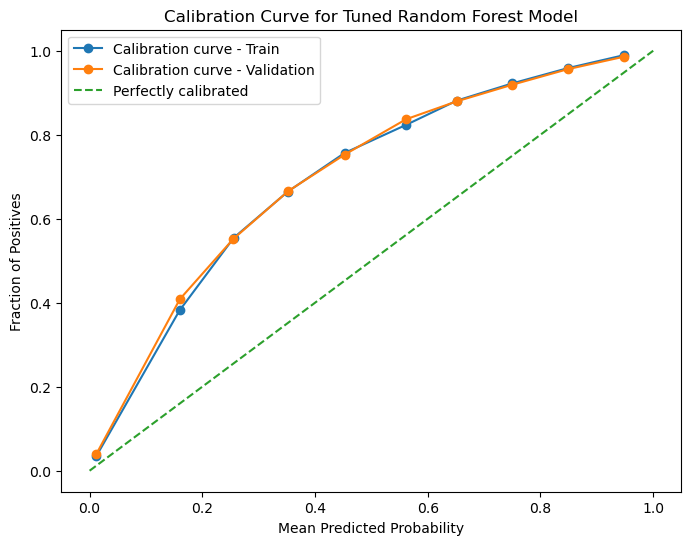

In [48]:
# Evaluate calibration curve
title = 'Calibration Curve for Tuned Random Forest Model'
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred_prob_rf_tuned, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_pred_prob_rf_tuned, n_bins=10) 
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Calibration curve - Train')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='Calibration curve - Validation')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title(title)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [49]:
# Quantify calibration using Brier Score
brier_score_train_rf = brier_score_loss(y_train, y_train_pred_prob_rf_tuned)
brier_score_val_rf = brier_score_loss(y_val, y_val_pred_prob_rf_tuned)
print(f"Tuned Random Forest - Train set Brier Score: {brier_score_train_rf:.4f}")
print(f"Tuned Random Forest - Validation set Brier Score: {brier_score_val_rf:.4f}")

Tuned Random Forest - Train set Brier Score: 0.1012
Tuned Random Forest - Validation set Brier Score: 0.1040


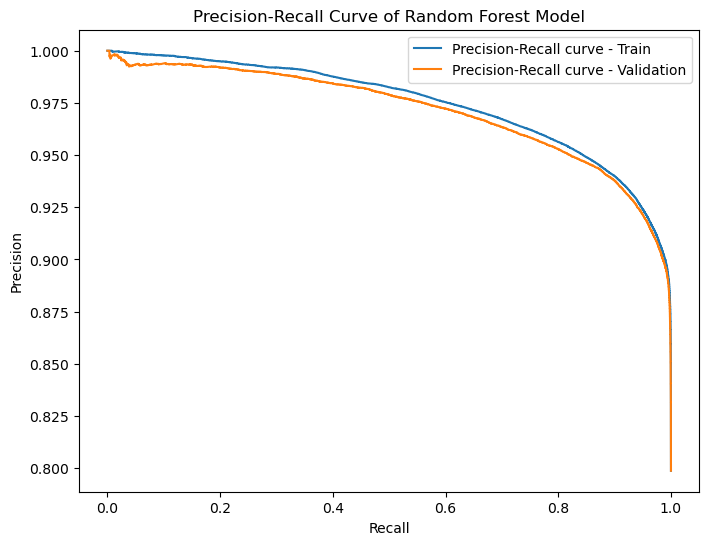

In [50]:
# Precision-Recall Curve
precision_train_rf, recall_train_rf, thresholds_train_rf = precision_recall_curve(y_train, y_train_pred_prob_rf_tuned)
precision_val_rf, recall_val_rf, thresholds_val_rf = precision_recall_curve(y_val, y_val_pred_prob_rf_tuned)
plt.figure(figsize=(8, 6))
plt.plot(recall_train_rf, precision_train_rf, label='Precision-Recall curve - Train')
plt.plot(recall_val_rf, precision_val_rf, label='Precision-Recall curve - Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Random Forest Model')
plt.legend()
plt.show()

In [51]:
# Average Precision Score (Area under Precision-Recall Curve)
average_precision_train_rf = average_precision_score(y_train, y_train_pred_prob_rf_tuned)
average_precision_val_rf = average_precision_score(y_val, y_val_pred_prob_rf_tuned)
print(f"Tuned Random Forest - Train set Average Precision Score: {average_precision_train_rf:.4f}")
print(f"Tuned Random Forest - Validation set Average Precision Score: {average_precision_val_rf:.4f}")

Tuned Random Forest - Train set Average Precision Score: 0.9746
Tuned Random Forest - Validation set Average Precision Score: 0.9712


Best threshold for Random Forest based on F1-score: 0.1833


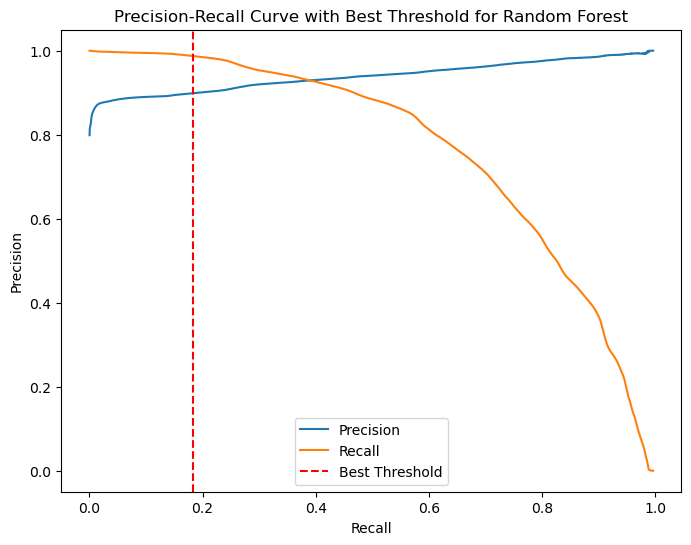

In [52]:
# Pick threshold based on business needs (maximizing F1-score)
f1_scores_rf = 2 * (precision_val_rf * recall_val_rf) / (precision_val_rf + recall_val_rf + 1e-10)
best_threshold_index_rf = np.argmax(f1_scores_rf)
best_threshold_rf = thresholds_val_rf[best_threshold_index_rf]
print(f"Best threshold for Random Forest based on F1-score: {best_threshold_rf:.4f}")
# Plot Precision-Recall Curve with best threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_val_rf, precision_val_rf[:-1], label='Precision')
plt.plot(thresholds_val_rf, recall_val_rf[:-1], label='Recall')
plt.axvline(x=best_threshold_rf, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold for Random Forest')
plt.legend()
plt.show()

In [53]:
# Evaluate model at the best threshold
y_train_pred_rf_best = (y_train_pred_prob_rf_tuned >= best_threshold_rf).astype(int)
y_val_pred_rf_best = (y_val_pred_prob_rf_tuned >= best_threshold_rf).astype(int)

print("Random Forest Model Evaluation at Best Threshold:")
print(f"Train Classification Report:\n{classification_report(y_train, y_train_pred_rf_best)}")
print(f"Validation Classification Report:\n{classification_report(y_val, y_val_pred_rf_best)}")

Random Forest Model Evaluation at Best Threshold:
Train Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.70     95600
           1       0.90      0.99      0.94    379595

    accuracy                           0.90    475195
   macro avg       0.91      0.78      0.82    475195
weighted avg       0.91      0.90      0.89    475195

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.56      0.69     23900
           1       0.90      0.99      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.91      0.77      0.82    118799
weighted avg       0.90      0.90      0.89    118799



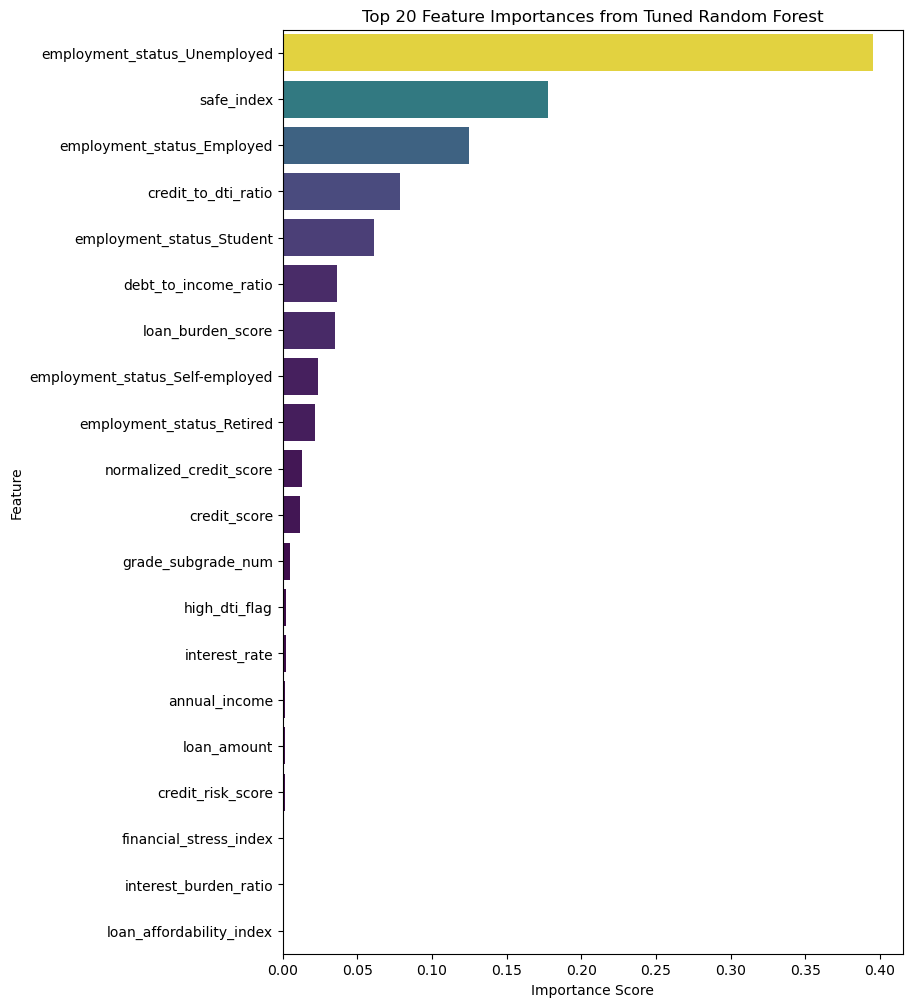

In [54]:
# Feature importance from Tuned Random Forest
importances = rf_model_tuned.feature_importances_
feature_names = X_train_tree.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(8, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis', hue='Importance', legend=False)
plt.title('Top 20 Feature Importances from Tuned Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#### 3. XGBoost Classifier Model

In [55]:
# XGBoost model
xgb_model = XGBClassifier(random_state=100, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tree, y_train)
# Predict probabilities
y_train_pred_prob_xgb = xgb_model.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_xgb = xgb_model.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
train_roc_auc_xgb = roc_auc_score(y_train, y_train_pred_prob_xgb)
val_roc_auc_xgb = roc_auc_score(y_val, y_val_pred_prob_xgb)
print("XGBoost Model - Train set ROC-AUC:", train_roc_auc_xgb)
print("XGBoost Model - Validation set ROC-AUC:", val_roc_auc_xgb)

XGBoost Model - Train set ROC-AUC: 0.930960067066083
XGBoost Model - Validation set ROC-AUC: 0.9177355830980138


The XGBoost model demonstrates strong performance with ROC-AUC scores of approximately 0.93 on the training set and 0.92 on the validation set. This indicates that the model is effective at distinguishing between borrowers who will repay their loans and those who will not, while also generalizing well to unseen data without significant overfitting. But still have room for improvement.

In [56]:
# Calculate scale_pos_weight for XGBoost
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

Scale Pos Weight: 0.25


In [57]:
# Use Randomized Search CV for Hyperparameter Tuning of XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=100, 
    n_jobs=-1, 
    use_label_encoder=False, 
    eval_metric='auc'
)
param_dist_xgb = {
    'n_estimators': randint(500, 1201),
    'learning_rate': uniform(0.001, 1.0 - 0.001),
    'max_depth': randint(3, 11),
    'min_child_weight': randint(5, 11),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': uniform(scale_pos_weight - 0.1, 0.2),
    'gamma': uniform(0.2, 1.0 - 0.2),
    'reg_alpha': loguniform(1e-8, 1.0),
    'reg_lambda': loguniform(1e-6, 1.0)
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

xgb_random_search = RandomizedSearchCV(estimator=xgb, 
                                       param_distributions=param_dist_xgb, 
                                       n_iter=15, 
                                       scoring='roc_auc', 
                                       cv=cv, 
                                       random_state=100, 
                                       n_jobs=-1)
xgb_random_search.fit(X_train_tree, y_train)

# Best parameters from Randomized Search
best_params_xgb = xgb_random_search.best_params_
print("Best Parameters from Randomized Search for XGBoost:", best_params_xgb)

Best Parameters from Randomized Search for XGBoost: {'colsample_bytree': 0.710706024558534, 'gamma': 0.39722870496283974, 'learning_rate': 0.17443439373846487, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 909, 'reg_alpha': 0.0006078402777103629, 'reg_lambda': 0.024423309800502824, 'scale_pos_weight': 0.21992440820504833, 'subsample': 0.7276166810131716}


In [58]:
# Train XGBoost with best parameters
xgb_model_tuned = XGBClassifier(**best_params_xgb, 
                         random_state=100, 
                         n_jobs=-1, 
                         use_label_encoder=False, 
                         eval_metric='auc')
xgb_model_tuned.fit(X_train_tree, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.710706024558534
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [59]:
# Predict and evaluate the tuned XGBoost model
y_train_pred_prob_xgb_tuned = xgb_model_tuned.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_xgb_tuned = xgb_model_tuned.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
roc_auc_train_xgb_model_tuned = roc_auc_score(y_train, y_train_pred_prob_xgb_tuned)
roc_auc_val_xgb_model_tuned = roc_auc_score(y_val, y_val_pred_prob_xgb_tuned)
print(f"XGBoost - Train set ROC-AUC Score: {roc_auc_train_xgb_model_tuned:.4f}")
print(f"XGBoost - Validation set ROC-AUC Score: {roc_auc_val_xgb_model_tuned:.4f}")

XGBoost - Train set ROC-AUC Score: 0.9284
XGBoost - Validation set ROC-AUC Score: 0.9188


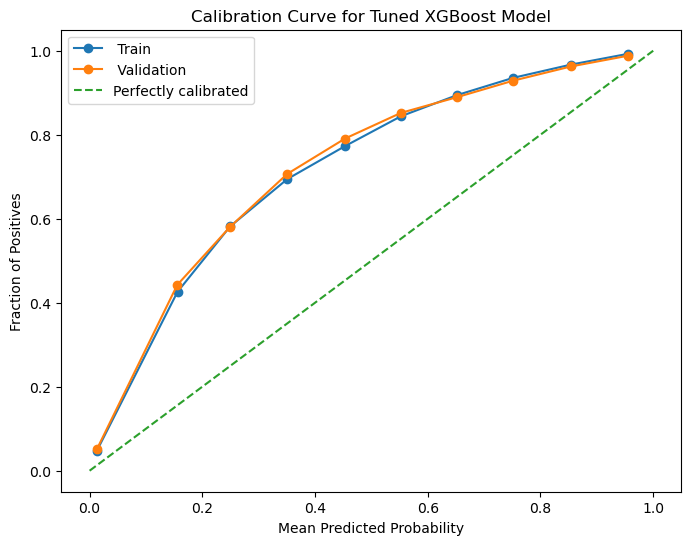

In [60]:
# Evaluate calibration curve
title = 'Calibration Curve for Tuned XGBoost Model'
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred_prob_xgb_tuned, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_pred_prob_xgb_tuned, n_bins=10) 
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label=' Train')
plt.plot(prob_pred_val, prob_true_val, marker='o', label=' Validation')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title(title)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [61]:
# Quantify calibration using Brier Score
brier_score_train_xgb = brier_score_loss(y_train, y_train_pred_prob_xgb_tuned)
brier_score_val_xgb = brier_score_loss(y_val, y_val_pred_prob_xgb_tuned)
print(f"XGBoost - Train set Brier Score: {brier_score_train_xgb:.4f}")
print(f"XGBoost - Validation set Brier Score: {brier_score_val_xgb:.4f}")

XGBoost - Train set Brier Score: 0.1050
XGBoost - Validation set Brier Score: 0.1087


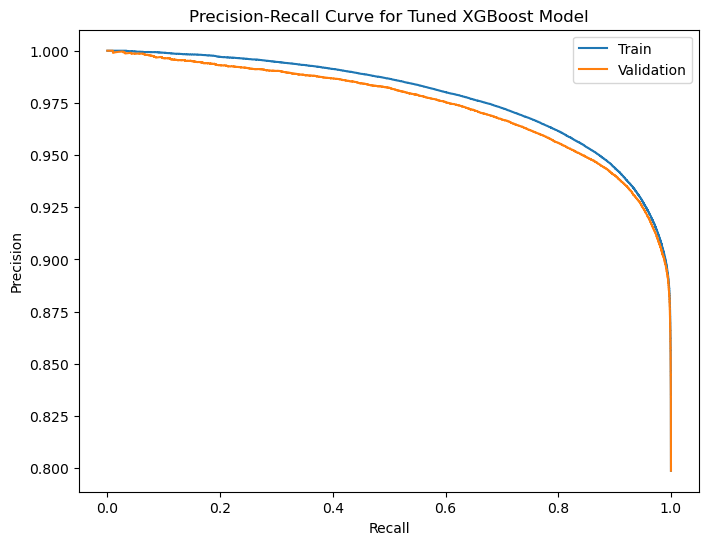

In [62]:
# Precision-Recall Curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_prob_xgb_tuned)
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred_prob_xgb_tuned)
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label='Train')
plt.plot(recall_val, precision_val, label='Validation')
plt.title('Precision-Recall Curve for Tuned XGBoost Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [63]:
# Average Precision Score (Area under Precision-Recall Curve)
average_precision_train_xgb = average_precision_score(y_train, y_train_pred_prob_xgb_tuned)
average_precision_val_xgb = average_precision_score(y_val, y_val_pred_prob_xgb_tuned)
print(f"XGBoost - Train set Average Precision Score: {average_precision_train_xgb:.4f}")
print(f"XGBoost - Validation set Average Precision Score: {average_precision_val_xgb:.4f}")

XGBoost - Train set Average Precision Score: 0.9780
XGBoost - Validation set Average Precision Score: 0.9739


Best Threshold (F1-score): 0.1773


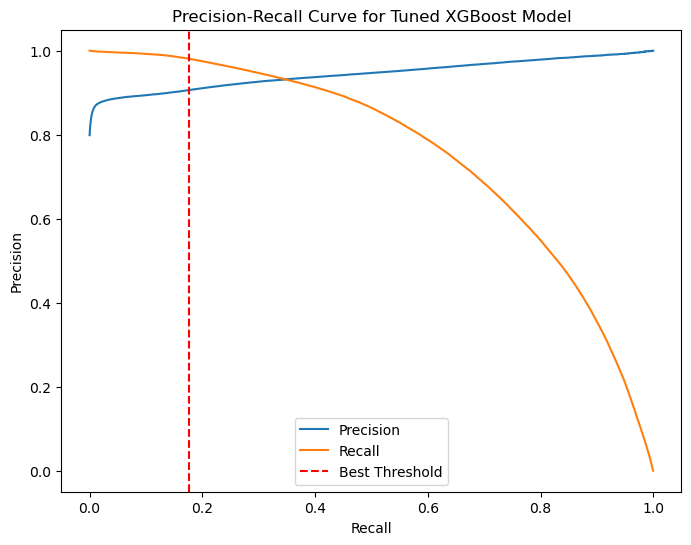

In [64]:
# Pick threshold based on business needs (maximizing F1-score)
f1_scores = 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-10)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds_val[best_threshold_index]
print(f"Best Threshold (F1-score): {best_threshold:.4f}")
# Plot Precision-Recall Curve with best threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_val, precision_val[:-1], label='Precision')
plt.plot(thresholds_val, recall_val[:-1], label='Recall')
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.title('Precision-Recall Curve for Tuned XGBoost Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [65]:
# Evaluate model at the best threshold
y_train_pred_best = (y_train_pred_prob_xgb_tuned >= best_threshold).astype(int)
y_val_pred_best = (y_val_pred_prob_xgb_tuned >= best_threshold).astype(int)
print(f"Train Classification Report (Best Threshold):\n{classification_report(y_train, y_train_pred_best)}")
print(f"Validation Classification Report (Best Threshold):\n{classification_report(y_val, y_val_pred_best)}")

Train Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.89      0.61      0.72     95600
           1       0.91      0.98      0.94    379595

    accuracy                           0.91    475195
   macro avg       0.90      0.79      0.83    475195
weighted avg       0.91      0.91      0.90    475195

Validation Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.89      0.60      0.71     23900
           1       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799



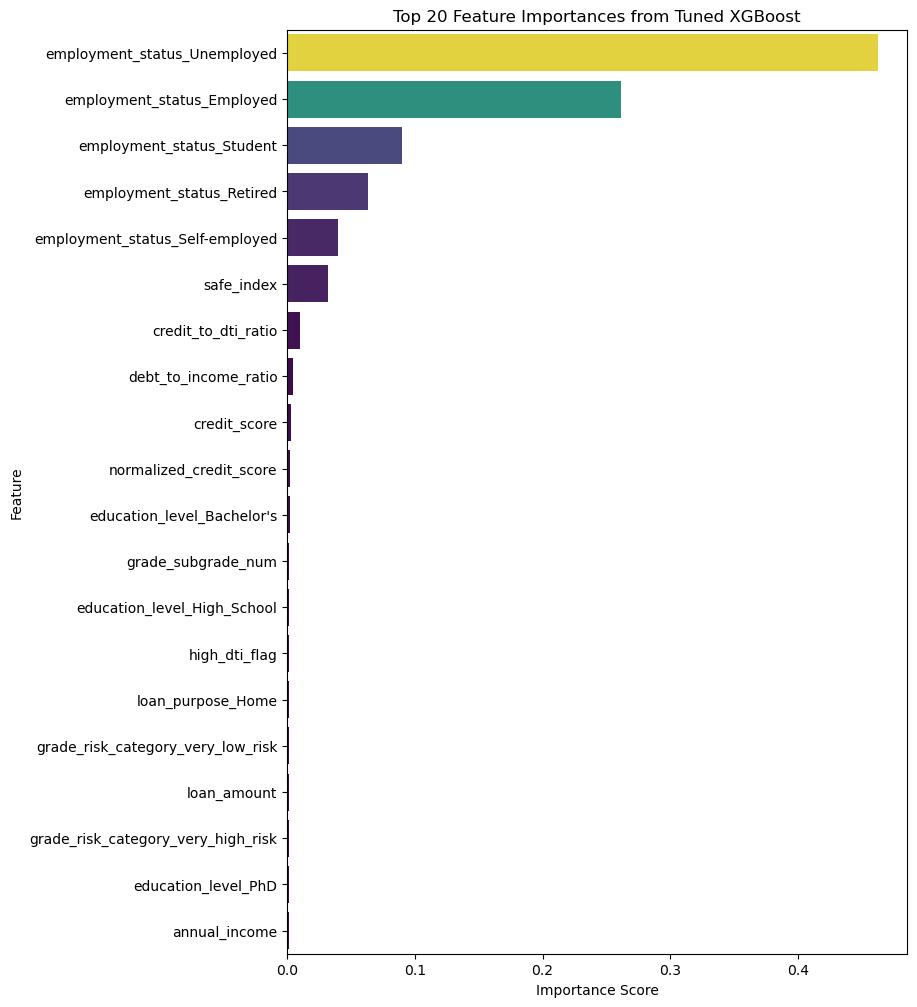

In [66]:
# Feature importance from Tuned XGBoost
importances = xgb_model_tuned.feature_importances_
feature_names = X_train_tree.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(8, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis', hue='Importance', legend=False)
plt.title('Top 20 Feature Importances from Tuned XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#### 4. LightGBM Classifier Model

In [67]:
# LightGBM model
lgbm_model = LGBMClassifier(random_state=100, n_jobs=-1)
lgbm_model.fit(X_train_tree, y_train)
# Predict probabilities
y_train_pred_prob_lgbm = lgbm_model.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_lgbm = lgbm_model.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
train_roc_auc_lgbm = roc_auc_score(y_train, y_train_pred_prob_lgbm)
val_roc_auc_lgbm = roc_auc_score(y_val, y_val_pred_prob_lgbm)
print("LightGBM Model - Train set ROC-AUC:", train_roc_auc_lgbm)
print("LightGBM Model - Validation set ROC-AUC:", val_roc_auc_lgbm)

[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3660
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
LightGBM Model - Train set ROC-AUC: 0.9229067608722596
LightGBM Model - Validation set ROC-AUC: 0.9180985071510293


The LightGBM model demonstrates strong performance with ROC-AUC scores of approximately 0.92 on both the training and validation sets. This indicates that the model is effective at distinguishing between borrowers who will repay their loans and those who will not, while also generalizing well to unseen data without significant overfitting. However, there is still room for improvement to further enhance the model's predictive capabilities.

In [68]:
import logging
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# Use Randomized Search CV for Hyperparameter Tuning of LightGBM
lgbm = LGBMClassifier(
    objective='binary',
    random_state=100, 
    n_jobs=-1, 
    metric='auc',
    importance_type='split'
)
param_dist_lgbm = {
    'n_estimators': randint(700, 2501),
    'num_leaves': randint(15, 64),
    'learning_rate': uniform(0.03, 1.0 - 0.03),
    'max_depth': randint(5, 9),
    'min_child_samples': randint(20, 51),
    'reg_alpha': uniform(0.001, 1.0 - 0.001),
    'reg_lambda': uniform(0.001, 1.0 - 0.001),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

lgbm_random_search = RandomizedSearchCV(estimator=lgbm,
                                        param_distributions=param_dist_lgbm,
                                        n_iter=20,
                                        scoring='roc_auc',
                                        cv=cv,
                                        random_state=100,
                                        n_jobs=-1,
                                        verbose=1)

lgbm_random_search.fit(
    X_train_tree, y_train,
    eval_set=[(X_val_tree, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(100), log_evaluation(50)]
)
# Best parameters from Randomized Search
best_params_lgbm = lgbm_random_search.best_params_
print("Best Parameters from Randomized Search for LightGBM:", best_params_lgbm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3660
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.914482
[100]	valid_0's auc: 0.917035
[150]	valid_0's auc: 0.918082
[200]	valid_0's auc: 0.918599
[250]	valid_0's auc: 0.919151
[300]	valid_0's auc: 0.919514
[350]	valid_0's auc: 0.919768
[400]	valid_0's auc: 0.919892
[450]	valid_0's auc: 0.920119
[500]	valid_0's auc: 0.920246
[550]	valid_0's auc

In [69]:
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)
# Predict and evaluate the tuned LightGBM model
#best_params_lgbm1 = {'learning_rate': 0.14131103464830524, 'max_depth': 6, 'min_child_samples': 22, 'n_estimators': 753, 'num_leaves': 16, 'reg_alpha': 0.9666430847928362, 'reg_lambda': 0.9570555877524454}
lgbm_model_tuned = LGBMClassifier(
    **best_params_lgbm,
    objective='binary',
    random_state=100, 
    n_jobs=-1, 
    metric='auc',
    importance_type='split' 
)
# Fit the tuned model
lgbm_model_tuned.fit(X_train_tree, y_train)

[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3660
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932


,boosting_type,'gbdt'
,num_leaves,17
,max_depth,8
,learning_rate,0.11929393527592146
,n_estimators,986
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,50


In [70]:
# Predict probabilities
y_train_pred_prob_lgbm_tuned = lgbm_model_tuned.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_lgbm_tuned = lgbm_model_tuned.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
roc_auc_train_lgbm_tuned = roc_auc_score(y_train, y_train_pred_prob_lgbm_tuned)
roc_auc_val_lgbm_tuned = roc_auc_score(y_val, y_val_pred_prob_lgbm_tuned)
print(f"LightGBM - Train set ROC-AUC: {roc_auc_train_lgbm_tuned:.4f}")
print(f"LightGBM - Validation set ROC-AUC: {roc_auc_val_lgbm_tuned:.4f}")

LightGBM - Train set ROC-AUC: 0.9375
LightGBM - Validation set ROC-AUC: 0.9204


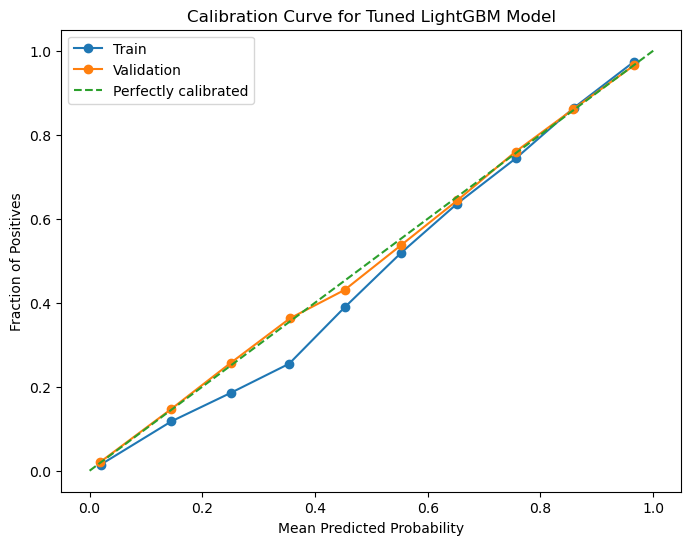

In [71]:
# Evaluate calibration curve
title = 'Calibration Curve for Tuned LightGBM Model'
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred_prob_lgbm_tuned, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_pred_prob_lgbm_tuned, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Train')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='Validation')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title(title)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [72]:
# Quantify calibration using Brier Score
brier_score_train_lgbm = brier_score_loss(y_train, y_train_pred_prob_lgbm_tuned)
brier_score_val_lgbm = brier_score_loss(y_val, y_val_pred_prob_lgbm_tuned)
print(f"Tuned LightGBM - Train set Brier Score: {brier_score_train_lgbm:.4f}")
print(f"Tuned LightGBM - Validation set Brier Score: {brier_score_val_lgbm:.4f}")

Tuned LightGBM - Train set Brier Score: 0.0658
Tuned LightGBM - Validation set Brier Score: 0.0722


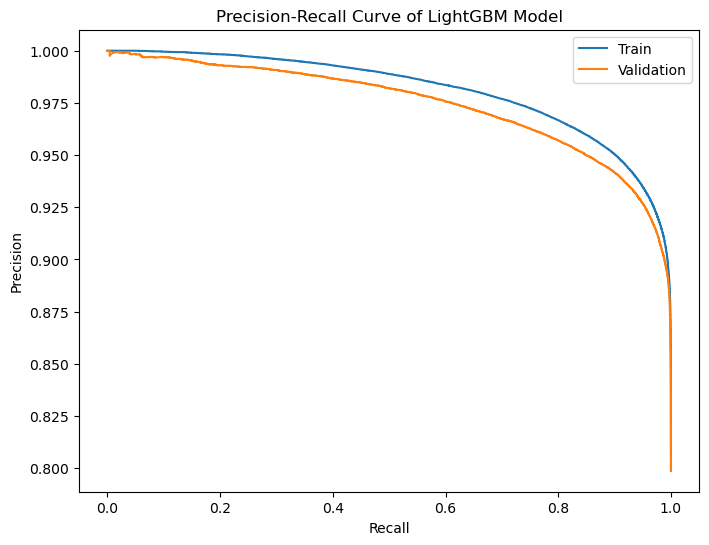

In [73]:
# Precision-Recall Curve
precision_train_lgbm, recall_train_lgbm, thresholds_train_lgbm = precision_recall_curve(y_train, y_train_pred_prob_lgbm_tuned)
precision_val_lgbm, recall_val_lgbm, thresholds_val_lgbm = precision_recall_curve(y_val, y_val_pred_prob_lgbm_tuned)
plt.figure(figsize=(8, 6))
plt.plot(recall_train_lgbm, precision_train_lgbm, label='Train')
plt.plot(recall_val_lgbm, precision_val_lgbm, label='Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of LightGBM Model')
plt.legend()
plt.show()

In [74]:
# Average Precision Score (Area under Precision-Recall Curve)
average_precision_train_lgbm = average_precision_score(y_train, y_train_pred_prob_lgbm_tuned)
average_precision_val_lgbm = average_precision_score(y_val, y_val_pred_prob_lgbm_tuned)
print(f"Tuned LightGBM - Train set Average Precision Score: {average_precision_train_lgbm:.4f}")
print(f"Tuned LightGBM - Validation set Average Precision Score: {average_precision_val_lgbm:.4f}")

Tuned LightGBM - Train set Average Precision Score: 0.9811
Tuned LightGBM - Validation set Average Precision Score: 0.9744


Best threshold for LightGBM based on F1-score: 0.5076


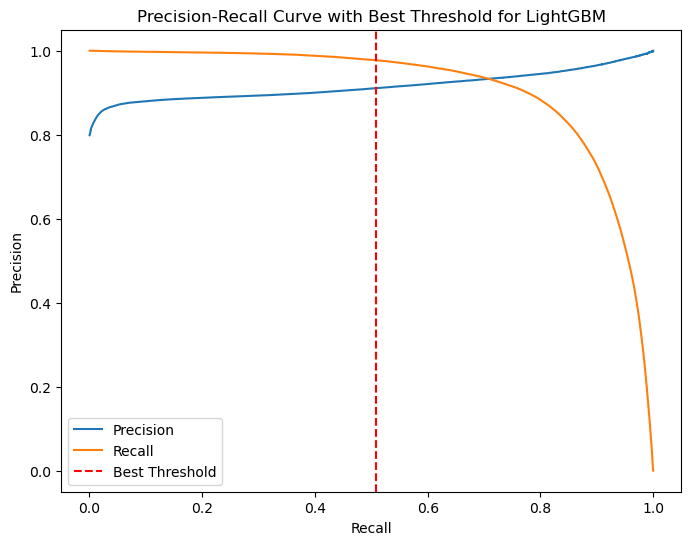

In [75]:
# Pick threshold based on business needs (maximizing F1-score)
f1_scores_lgbm = 2 * (precision_val_lgbm * recall_val_lgbm) / (precision_val_lgbm + recall_val_lgbm + 1e-10)
best_threshold_index_lgbm = np.argmax(f1_scores_lgbm)
best_threshold_lgbm = thresholds_val_lgbm[best_threshold_index_lgbm]
print(f"Best threshold for LightGBM based on F1-score: {best_threshold_lgbm:.4f}")
# Plot Precision-Recall Curve with best threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_val_lgbm, precision_val_lgbm[:-1], label='Precision')
plt.plot(thresholds_val_lgbm, recall_val_lgbm[:-1], label='Recall')
plt.axvline(x=best_threshold_lgbm, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold for LightGBM')
plt.legend()
plt.show()

In [76]:
# Evaluate model at the best threshold
y_train_pred_lgbm_tuned = (y_train_pred_prob_lgbm_tuned >= best_threshold_lgbm).astype(int)
y_val_pred_lgbm_tuned = (y_val_pred_prob_lgbm_tuned >= best_threshold_lgbm).astype(int)
print("LightGBM Model Evaluation at Best Threshold:")
print(f"Train Classification Report:\n{classification_report(y_train, y_train_pred_lgbm_tuned)}")
print(f"Validation Classification Report:\n{classification_report(y_val, y_val_pred_lgbm_tuned)}")

LightGBM Model Evaluation at Best Threshold:
Train Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.64      0.75     95600
           1       0.92      0.98      0.95    379595

    accuracy                           0.91    475195
   macro avg       0.91      0.81      0.85    475195
weighted avg       0.91      0.91      0.91    475195

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.73     23900
           1       0.91      0.98      0.94     94899

    accuracy                           0.91    118799
   macro avg       0.89      0.80      0.83    118799
weighted avg       0.90      0.91      0.90    118799



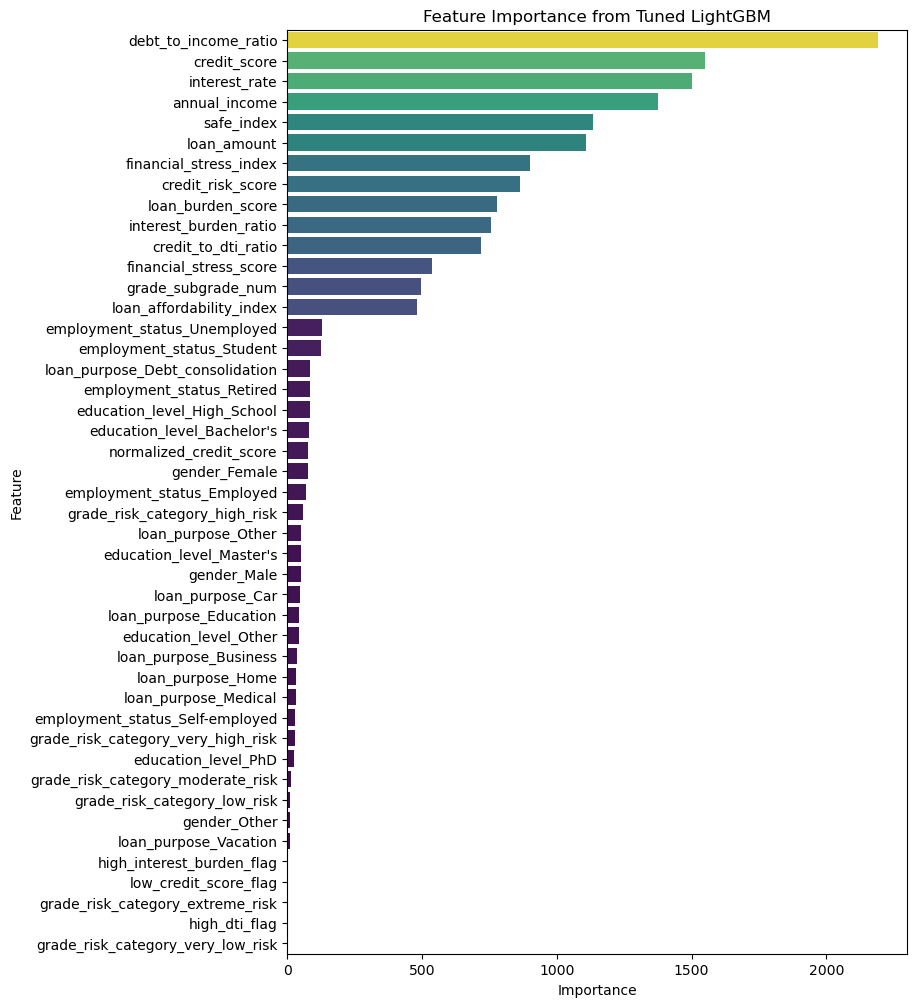

In [77]:
# Important feature from Tuned LightGBM
importances = lgbm_model_tuned.feature_importances_
feature_names = X_train_tree.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(8, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Importance', legend=False)
plt.title('Feature Importance from Tuned LightGBM')
plt.show()

#### 5. Ensembling Models (Stacking)

In [78]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [79]:
# Stacking Classifier with Tuned Models
# Define base learners
estimators = [
    ('rf', rf_model_tuned),
    ('xgb', xgb_model_tuned),
    ('lgbm', lgbm_model_tuned)
]
# Meta-model
meta_model = LogisticRegression(max_iter=2000, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    n_jobs=-1,
    cv=cv
)
# Fit stacking classifier
stacking_clf.fit(X_train_tree, y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,final_estimator,"LogisticRegre...00, n_jobs=-1)"
,cv,StratifiedKFo... shuffle=True)
,stack_method,'auto'
,n_jobs,-1
,passthrough,False
,verbose,0
,n_estimators,250
,criterion,'gini'
,max_depth,10
,min_samples_split,15


In [80]:
# Predict and evaluate the Stacking Classifier
y_train_pred_prob_stack = stacking_clf.predict_proba(X_train_tree)[:, 1]
y_val_pred_prob_stack = stacking_clf.predict_proba(X_val_tree)[:, 1]
# ROC-AUC scores
train_roc_auc_stack = roc_auc_score(y_train, y_train_pred_prob_stack)
val_roc_auc_stack = roc_auc_score(y_val, y_val_pred_prob_stack)
print(f"Stacking Classifier - Train set ROC-AUC: {train_roc_auc_stack:.4f}")
print(f"Stacking Classifier - Validation set ROC-AUC: {val_roc_auc_stack:.4f}")

Stacking Classifier - Train set ROC-AUC: 0.9338
Stacking Classifier - Validation set ROC-AUC: 0.9204


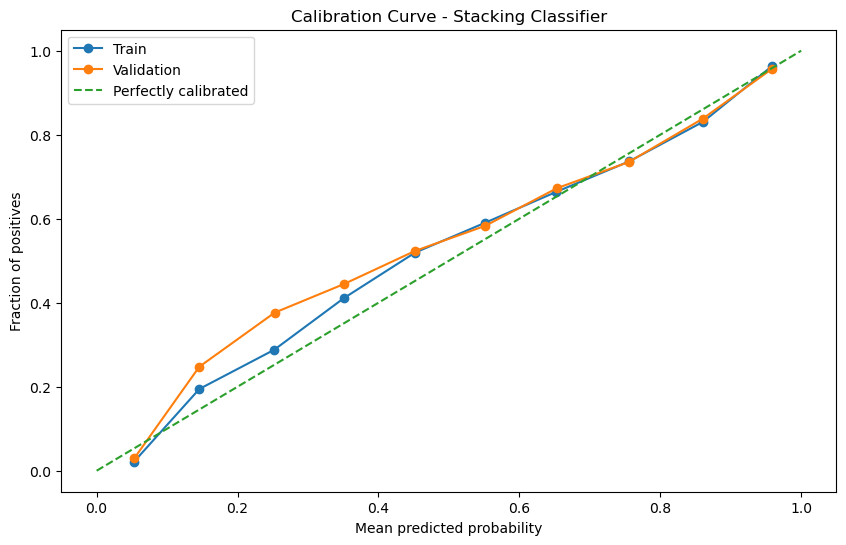

In [81]:
# Calibration curve for stacking classifier
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred_prob_stack, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_pred_prob_stack, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Train')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='Validation')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve - Stacking Classifier')
plt.legend()
plt.show()

In [82]:
# Quantify calibration using Brier Score
brier_score_train_stack = brier_score_loss(y_train, y_train_pred_prob_stack)
brier_score_val_stack = brier_score_loss(y_val, y_val_pred_prob_stack)
print(f"Stacking Classifier - Train set Brier Score: {brier_score_train_stack:.4f}")
print(f"Stacking Classifier - Validation set Brier Score: {brier_score_val_stack:.4f}")

Stacking Classifier - Train set Brier Score: 0.0675
Stacking Classifier - Validation set Brier Score: 0.0731


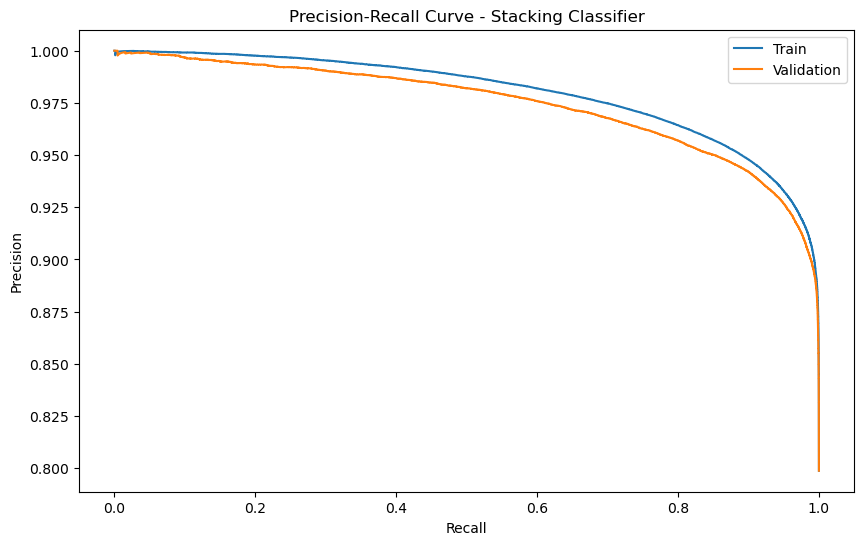

In [83]:
# Precision-Recall Curve for stacking classifier
precision_train_stack, recall_train_stack, thresholds_train_stack = precision_recall_curve(y_train, y_train_pred_prob_stack)
precision_val_stack, recall_val_stack, thresholds_val_stack = precision_recall_curve(y_val, y_val_pred_prob_stack)
plt.figure(figsize=(10, 6))
plt.plot(recall_train_stack, precision_train_stack, label='Train')
plt.plot(recall_val_stack, precision_val_stack, label='Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Stacking Classifier')
plt.legend()
plt.show()

In [84]:
# Average Precision Score (Area under Precision-Recall Curve) for stacking classifier
average_precision_train_stack = average_precision_score(y_train, y_train_pred_prob_stack)
average_precision_val_stack = average_precision_score(y_val, y_val_pred_prob_stack)
print(f"Stacking Classifier - Train set Average Precision Score: {average_precision_train_stack:.4f}")
print(f"Stacking Classifier - Validation set Average Precision Score: {average_precision_val_stack:.4f}")

Stacking Classifier - Train set Average Precision Score: 0.9797
Stacking Classifier - Validation set Average Precision Score: 0.9744


Best threshold for stacking classifier based on F1-score: 0.3944258842287687


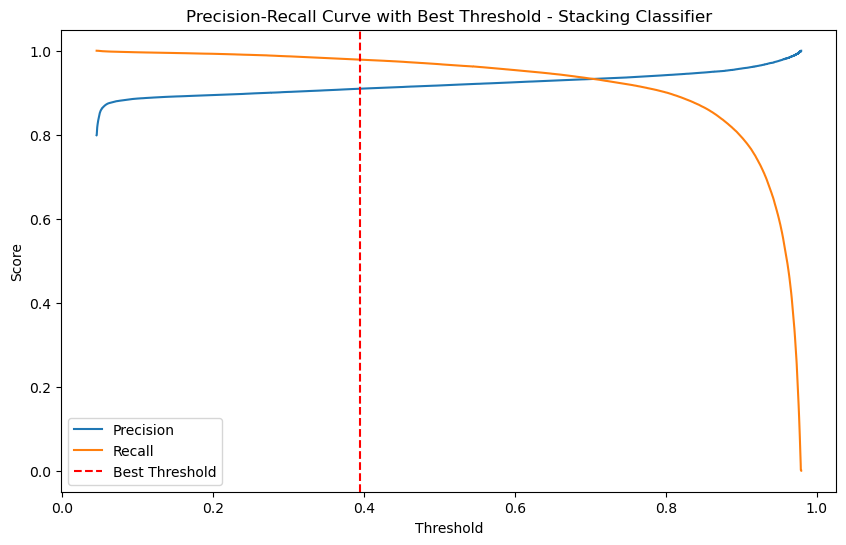

In [85]:
# Pick threshold based on business needs (maximizing F1-score) for stacking classifier
f1_scores_stack = 2 * (precision_val_stack * recall_val_stack) / (precision_val_stack + recall_val_stack + 1e-10)
best_threshold_index_stack = np.argmax(f1_scores_stack)
best_threshold_stack = thresholds_val_stack[best_threshold_index_stack]
print("Best threshold for stacking classifier based on F1-score:", best_threshold_stack)
# Plot Precision-Recall Curve with best threshold for stacking classifier
plt.figure(figsize=(10, 6))
plt.plot(thresholds_val_stack, precision_val_stack[:-1], label='Precision')
plt.plot(thresholds_val_stack, recall_val_stack[:-1], label='Recall')
plt.axvline(x=best_threshold_stack, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve with Best Threshold - Stacking Classifier')
plt.legend()
plt.show()

In [86]:
# Evaluate model at the best threshold for stacking classifier
y_train_pred_stack = (y_train_pred_prob_stack >= best_threshold_stack).astype(int)
y_val_pred_stack = (y_val_pred_prob_stack >= best_threshold_stack).astype(int)
print("Stacking Classifier Evaluation at Best Threshold:")
print(f"Train Classification Report:\n{classification_report(y_train, y_train_pred_stack)}")
print(f"Validation Classification Report:\n{classification_report(y_val, y_val_pred_stack)}")

Stacking Classifier Evaluation at Best Threshold:
Train Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     95600
           1       0.91      0.98      0.95    379595

    accuracy                           0.91    475195
   macro avg       0.91      0.81      0.85    475195
weighted avg       0.91      0.91      0.91    475195

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72     23900
           1       0.91      0.98      0.94     94899

    accuracy                           0.91    118799
   macro avg       0.89      0.80      0.83    118799
weighted avg       0.90      0.91      0.90    118799



#### 6. Neural Network Model

In [87]:
# Prepare data for neural network
X_train_nn = X_train_logistic.copy()
X_val_nn = X_val_logistic.copy()
print("X_train_nn shape:", X_train_nn.shape)
print("X_val_nn shape:", X_val_nn.shape)
print(X_train_nn.info())
print(X_val_nn.info())

X_train_nn shape: (475195, 45)
X_val_nn shape: (118799, 45)
<class 'pandas.core.frame.DataFrame'>
Index: 475195 entries, 236143 to 22031
Data columns (total 45 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   annual_income                       475195 non-null  float64
 1   debt_to_income_ratio                475195 non-null  float64
 2   credit_score                        475195 non-null  float64
 3   loan_amount                         475195 non-null  float64
 4   interest_rate                       475195 non-null  float64
 5   grade_subgrade_num                  475195 non-null  float64
 6   interest_burden_ratio               475195 non-null  float64
 7   credit_risk_score                   475195 non-null  float64
 8   financial_stress_index              475195 non-null  float64
 9   financial_stress_score              475195 non-null  float64
 10  loan_burden_score                

In [88]:
# Check nan and infinite values
print("Checking for NaN and infinite values in X_train_nn:")
print("NaN values:\n", X_train_nn.isna().sum())
print("Infinite values:\n", np.isinf(X_train_nn).sum())
print("Checking for NaN and infinite values in X_val_nn:")
print("NaN values:\n", X_val_nn.isna().sum())
print("Infinite values:\n", np.isinf(X_val_nn).sum())

Checking for NaN and infinite values in X_train_nn:
NaN values:
 annual_income                         0
debt_to_income_ratio                  0
credit_score                          0
loan_amount                           0
interest_rate                         0
grade_subgrade_num                    0
interest_burden_ratio                 0
credit_risk_score                     0
financial_stress_index                0
financial_stress_score                0
loan_burden_score                     0
credit_to_dti_ratio                   0
loan_affordability_index              0
low_credit_score_flag                 0
high_dti_flag                         0
safe_index                            0
normalized_credit_score               0
high_interest_burden_flag             0
gender_Female                         0
gender_Male                           0
gender_Other                          0
education_level_Bachelor's            0
education_level_High_School           0
education_level

In [89]:
# Ensure that the validation set has the same columns as the training set
X_val_nn = X_val_nn.reindex(columns=X_train_nn.columns, fill_value=0)

In [90]:
# Clean previous Keras session
tf.keras.backend.clear_session()
# Build Neural Network model
nn_model = Sequential(
    [
        tf.keras.Input(shape=(int(X_train_nn.shape[1]),)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        BatchNormalization(),
        Dropout(0.3),        
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        BatchNormalization(),
        Dropout(0.2),        
        Dense(1, activation='sigmoid')
    ]
)
# Optimizer with initial learning rate (use a float so ReduceLROnPlateau can modify it)
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
# Compile the model
metric = tf.keras.metrics.AUC(name='auc')
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metric])
# Callback for early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, mode='max', min_lr=1e-6, verbose=1)
# Train the model
history = nn_model.fit(
    X_train_nn, y_train,
    validation_data=(X_val_nn, y_val),
    epochs=100,
    batch_size=1024,
    callbacks=[early_stopping_callback, rlr],
    verbose=1
)

Epoch 1/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - auc: 0.8711 - loss: 0.3657 - val_auc: 0.9083 - val_loss: 0.2977 - learning_rate: 0.0010
Epoch 2/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - auc: 0.9031 - loss: 0.3003 - val_auc: 0.9102 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 3/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - auc: 0.9062 - loss: 0.2886 - val_auc: 0.9105 - val_loss: 0.2797 - learning_rate: 0.0010
Epoch 4/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - auc: 0.9075 - loss: 0.2803 - val_auc: 0.9106 - val_loss: 0.2741 - learning_rate: 0.0010
Epoch 5/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - auc: 0.9083 - loss: 0.2745 - val_auc: 0.9105 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 6/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - auc: 0.9090 - loss: 0.2701 - val_auc: 0.9105 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 7/100
465/465 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - auc: 0.9091 - loss: 0.2675 - val_auc: 0.9105 - val_loss: 0.2656 - learnin

In [91]:
# Predict probabilities
y_train_pred_prob_nn = nn_model.predict(X_train_nn).ravel()
y_val_pred_prob_nn = nn_model.predict(X_val_nn).ravel()
# ROC-AUC scores
train_roc_auc_nn = roc_auc_score(y_train, y_train_pred_prob_nn)
val_roc_auc_nn = roc_auc_score(y_val, y_val_pred_prob_nn)
print(f"Neural Network - Train set ROC-AUC: {train_roc_auc_nn:.4f}")
print(f"Neural Network - Validation set ROC-AUC: {val_roc_auc_nn:.4f}")

14850/14850 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Neural Network - Train set ROC-AUC: 0.9148
Neural Network - Validation set ROC-AUC: 0.9113


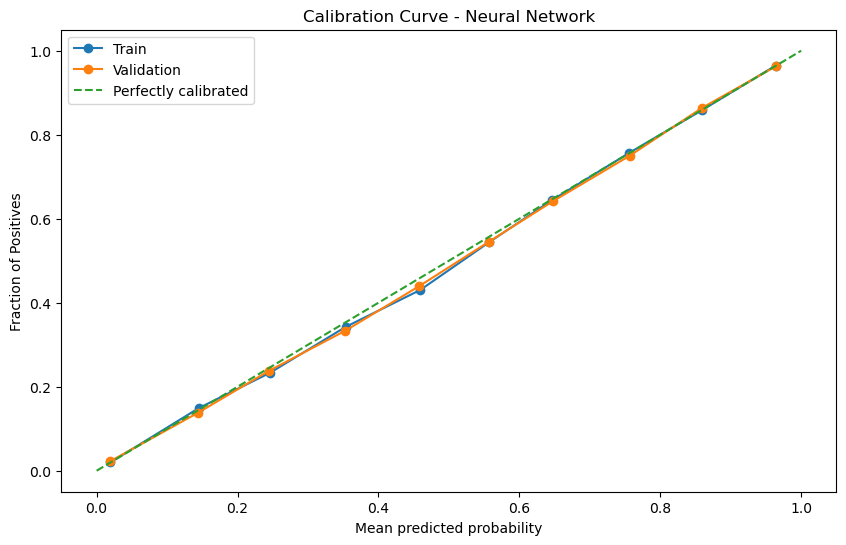

In [92]:
# Calibration curve for neural network
prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_pred_prob_nn, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_val_pred_prob_nn, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_train, prob_true_train, marker='o', label='Train')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='Validation')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Neural Network')
plt.legend()
plt.show()

In [93]:
# Quantify calibration using Brier Score
brier_score_train_nn = brier_score_loss(y_train, y_train_pred_prob_nn)
brier_score_val_nn = brier_score_loss(y_val, y_val_pred_prob_nn)
print(f"Neural Network - Train set Brier Score: {brier_score_train_nn:.4f}")
print(f"Neural Network - Validation set Brier Score: {brier_score_val_nn:.4f}")

Neural Network - Train set Brier Score: 0.0743
Neural Network - Validation set Brier Score: 0.0756


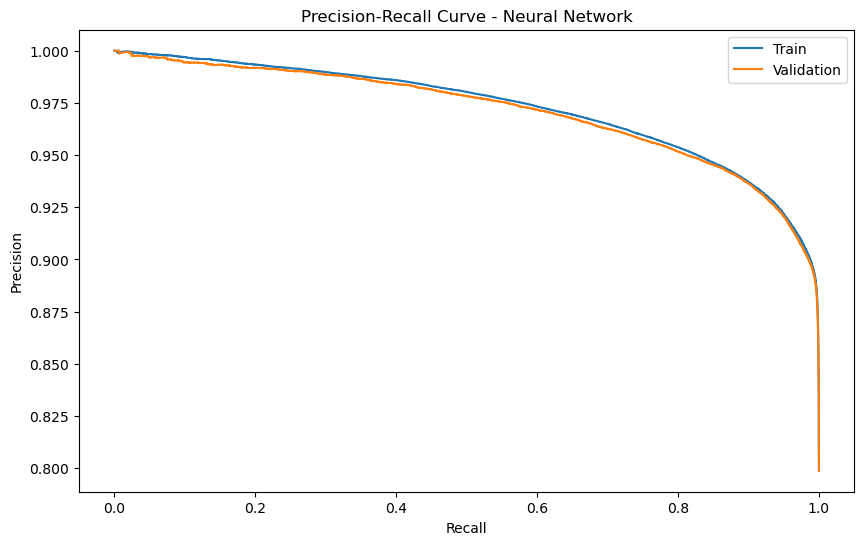

In [94]:
# Precision-Recall Curve for neural network
precision_train_nn, recall_train_nn, thresholds_train_nn = precision_recall_curve(y_train, y_train_pred_prob_nn)
precision_val_nn, recall_val_nn, thresholds_val_nn = precision_recall_curve(y_val, y_val_pred_prob_nn)
plt.figure(figsize=(10, 6))
plt.plot(recall_train_nn, precision_train_nn, label='Train')
plt.plot(recall_val_nn, precision_val_nn, label='Validation')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Neural Network')
plt.legend()
plt.show()

In [95]:
# Average Precision Score (Area under Precision-Recall Curve)
average_precision_train_nn = average_precision_score(y_train, y_train_pred_prob_nn)
average_precision_val_nn = average_precision_score(y_val, y_val_pred_prob_nn)
print(f"Neural Network - Train set Average Precision Score: {average_precision_train_nn:.4f}")
print(f"Neural Network - Validation set Average Precision Score: {average_precision_val_nn:.4f}")

Neural Network - Train set Average Precision Score: 0.9726
Neural Network - Validation set Average Precision Score: 0.9710


Best threshold for neural network based on F1-score: 0.46035665


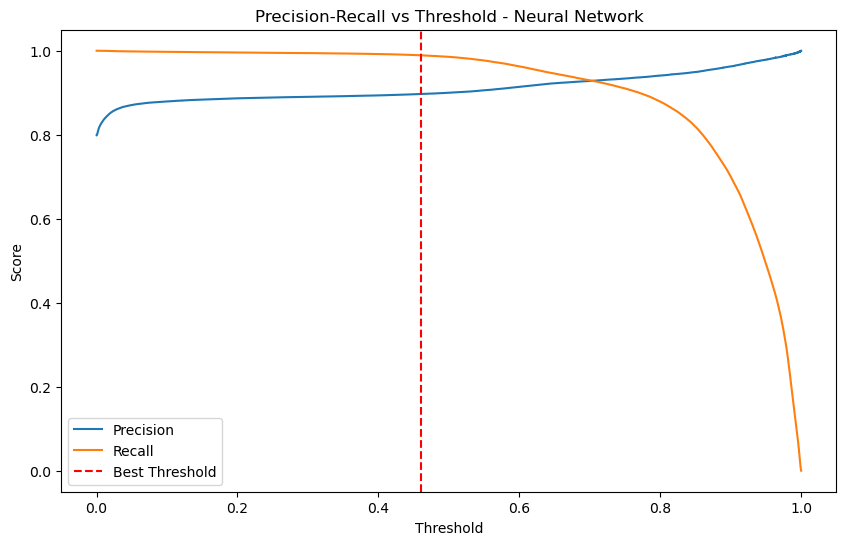

In [96]:
# Pick threshold based on business needs (maximizing F1-score) for neural network
f1_scores_nn = 2 * (precision_val_nn * recall_val_nn) / (precision_val_nn + recall_val_nn + 1e-10)
best_threshold_index_nn = np.argmax(f1_scores_nn)
best_threshold_nn = thresholds_val_nn[best_threshold_index_nn]
print("Best threshold for neural network based on F1-score:", best_threshold_nn)
# Plot Precision-Recall Curve with best threshold for neural network
plt.figure(figsize=(10, 6))
plt.plot(thresholds_val_nn, precision_val_nn[:-1], label='Precision')
plt.plot(thresholds_val_nn, recall_val_nn[:-1], label='Recall')
plt.axvline(x=best_threshold_nn, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold - Neural Network')
plt.legend()
plt.show()

In [97]:
# Evaluate model at the best threshold for neural network
y_train_pred_nn = (y_train_pred_prob_nn >= best_threshold_nn).astype(int)
y_val_pred_nn = (y_val_pred_prob_nn >= best_threshold_nn).astype(int)
print("Neural Network Evaluation at Best Threshold:")
print(f"Train Classification Report:\n{classification_report(y_train, y_train_pred_nn)}")
print(f"Validation Classification Report:\n{classification_report(y_val, y_val_pred_nn)}")

Neural Network Evaluation at Best Threshold:
Train Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.56      0.70     95600
           1       0.90      0.99      0.94    379595

    accuracy                           0.90    475195
   macro avg       0.91      0.77      0.82    475195
weighted avg       0.90      0.90      0.89    475195

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.55      0.69     23900
           1       0.90      0.99      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.91      0.77      0.82    118799
weighted avg       0.90      0.90      0.89    118799



#### Comparing Models' Performance


In [98]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network', 'Stacking Classifier']
model_val_results = {
    'ROC-AUC': [val_roc_auc_lr, val_roc_auc_rf_tuned, roc_auc_val_xgb_model_tuned, roc_auc_val_lgbm_tuned, val_roc_auc_nn, val_roc_auc_stack],
    'Brier Score': [brier_score_val_lr, brier_score_val_rf, brier_score_val_xgb, brier_score_val_lgbm, brier_score_val_nn, brier_score_val_stack],
    'Average Precision (AUC-PR)': [average_precision_val_lr, average_precision_val_rf, average_precision_val_xgb, average_precision_val_lgbm, average_precision_val_nn, average_precision_val_stack],
}
model_comparison_df = pd.DataFrame(model_val_results, index=models)
print("Model Comparison on Validation Set:")
print(model_comparison_df.sort_values(by='ROC-AUC', ascending=False))

Model Comparison on Validation Set:
                      ROC-AUC  Brier Score  Average Precision (AUC-PR)
Stacking Classifier  0.920423     0.073075                    0.974408
LightGBM             0.920399     0.072187                    0.974378
XGBoost              0.918842     0.108663                    0.973925
Random Forest        0.912710     0.104030                    0.971235
Neural Network       0.911271     0.075587                    0.971039
Logistic Regression  0.793664     0.128313                    0.934097


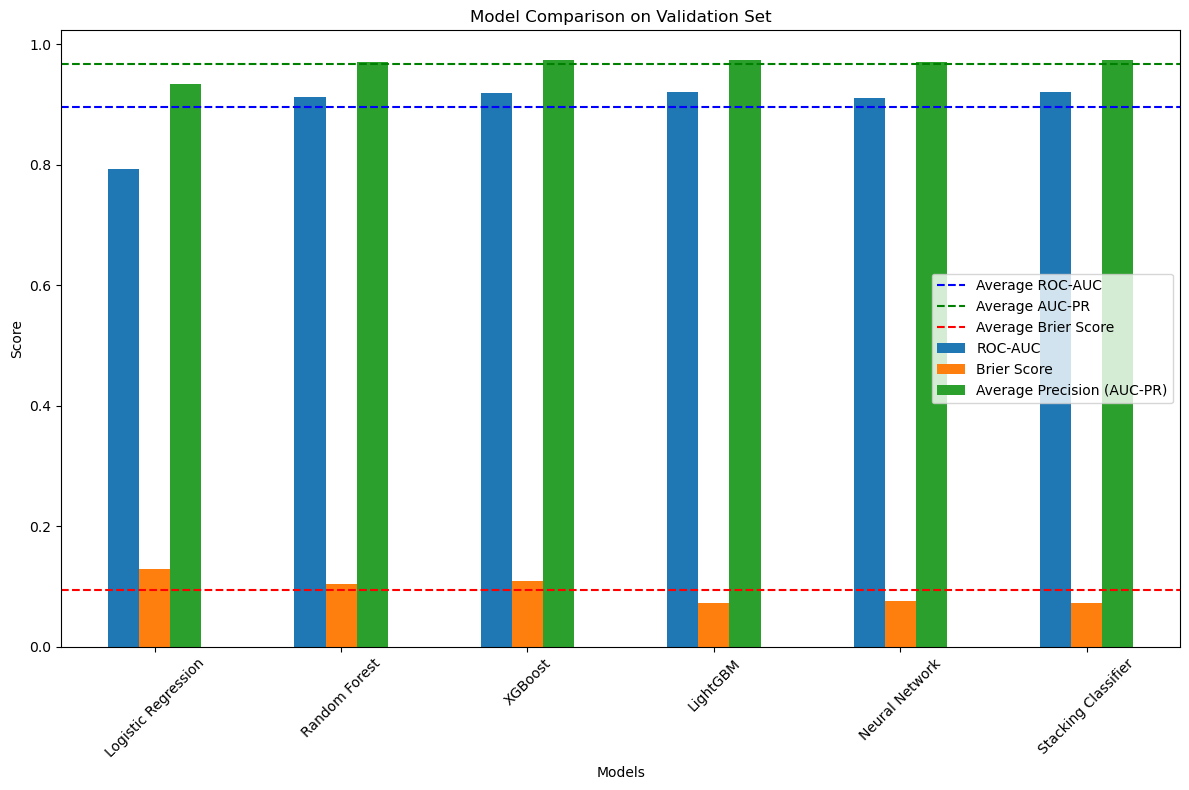

In [99]:
# Plot model comparison
model_comparison_df.plot(kind='bar', figsize=(12, 8))
plt.title("Model Comparison on Validation Set")
# Horizontal line for average of ROC-AUC
plt.axhline(y=model_comparison_df['ROC-AUC'].mean(), color='b', linestyle='--', label='Average ROC-AUC')
plt.axhline(y=model_comparison_df['Average Precision (AUC-PR)'].mean(), color='g', linestyle='--', label='Average AUC-PR')
plt.axhline(y=model_comparison_df['Brier Score'].mean(), color='r', linestyle='--', label='Average Brier Score')
plt.ylabel("Score")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The model comparison on the validation set reveals that the LightGBM model outperforms the other models across all three evaluation metrics: ROC-AUC, Brier Score, and Average Precision (AUC-PR). Specifically, LightGBM achieves the highest ROC-AUC score of 0.920399, indicating its superior ability to distinguish between borrowers who will repay their loans and those who will not. Additionally, it has the lowest Brier Score of 0.072187, suggesting that its predicted probabilities are well-calibrated. Furthermore, LightGBM attains the highest Average Precision score of 0.974378, demonstrating its effectiveness in balancing precision and recall for the positive class (loan repayment). Overall, LightGBM emerges as the best-performing model for predicting loan repayment in this analysis.

In [100]:
# Porfolios high ROC-AUC and Average Precision Score
p_lighgbm = y_val_pred_prob_lgbm_tuned
p_stack = y_val_pred_prob_stack
p_xgb = y_val_pred_prob_xgb_tuned
best = None
np.random.seed(100)
for _ in range(3000):
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    p_ensemble = (
        (weights[0] * p_lighgbm) + \
        (weights[1] * p_xgb) + \
        (weights[2] * p_stack)
    )
    roc_auc = roc_auc_score(y_val, p_ensemble)
    avg_precision = average_precision_score(y_val, p_ensemble)
    brier = brier_score_loss(y_val, p_ensemble)
    if best is None or roc_auc > best[0]:
        best = (roc_auc, avg_precision, brier, weights)
best_auc, best_ap, best_brier, best_weights = best

print(f"Best Ensemble Weights (Random Search) - LightGBM: {best_weights[0]:.2f}, XGBoost: {best_weights[1]:.2f}, Stacking: {best_weights[2]:.2f}")
print(f"Ensemble ROC-AUC: {best_auc:.4f}, Average Precision: {best_ap:.4f}, Brier Score: {best_brier:.4f}")

Best Ensemble Weights (Random Search) - LightGBM: 0.47, XGBoost: 0.03, Stacking: 0.50
Ensemble ROC-AUC: 0.9206, Average Precision: 0.9745, Brier Score: 0.0723


#### Final Ensemble Model Performance

The combined ensemble model, which incorporates LightGBM, Stacking Classifier, and XGBoost with weights of 0.47, 0.50, and 0.03 respectively, demonstrates robust performance on the validation set. The ensemble achieves a ROC-AUC score of 0.9206, indicating its strong ability to differentiate between borrowers who will repay their loans and those who will not. Additionally, it attains an AUC-PR score of 0.9745, reflecting its effectiveness in balancing precision and recall for the positive class (loan repayment).
The Brier Score of 0.0723 further suggests that the ensemble's predicted probabilities are well-calibrated. Overall, the ensemble model effectively leverages the strengths of its constituent models to deliver reliable predictions for loan repayment.

#### Make Predictions on Test Set
Using the ensemble model with weights from the validation set, we predict the probabilities of loan repayment on the test set.

In [101]:
# Load the test data
df_test = pd.read_csv('test.csv')
print("Test data shape:", df_test.shape)
df_test.head()

Test data shape: (254569, 12)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [102]:
# Check the structure of the test data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    254569 non-null  int64  
 1   annual_income         254569 non-null  float64
 2   debt_to_income_ratio  254569 non-null  float64
 3   credit_score          254569 non-null  int64  
 4   loan_amount           254569 non-null  float64
 5   interest_rate         254569 non-null  float64
 6   gender                254569 non-null  object 
 7   marital_status        254569 non-null  object 
 8   education_level       254569 non-null  object 
 9   employment_status     254569 non-null  object 
 10  loan_purpose          254569 non-null  object 
 11  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 23.3+ MB


In [103]:
# Check for missing values in test data
missing_values_test = df_test.isnull().sum()
print("Missing values in test data:\n", missing_values_test)

Missing values in test data:
 id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64


In [104]:
# Subcategory encoding for grade_subgrade
df_test['grade_risk_category'] = df_test['grade_subgrade'].apply(mapping_grade_subgrade).astype('category')
# Drop original grade_subgrade column
df_test = df_test.drop(columns=['grade_subgrade'])

In [105]:
# Apply feature engineering on test data
df_test_fe = feature_engineering(df_test)

In [106]:
# Categorial encoding on test data
catagorical_cols = df_test_fe.select_dtypes(include=['object', 'category']).columns.tolist()
df_test_encoded = pd.get_dummies(df_test_fe, columns=catagorical_cols, dtype=int)
df_test_encoded = df_test_encoded.rename(columns=lambda x: x.strip().replace(' ', '_').replace('-', '_'))
# Align test data columns with training data columns
df_test_encoded = df_test_encoded.reindex(columns=X_train_logistic.columns, fill_value=0)
print("Encoded test data shape:", df_test_encoded.shape)

Encoded test data shape: (254569, 45)


In [107]:
df_test_encoded.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,grade_subgrade_num,interest_burden_ratio,credit_risk_score,financial_stress_index,financial_stress_score,...,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation,grade_risk_category_extreme_risk,grade_risk_category_high_risk,grade_risk_category_low_risk,grade_risk_category_moderate_risk,grade_risk_category_very_high_risk,grade_risk_category_very_low_risk
0,28781.05,0.049,626,11461.42,14.73,0,5.865898,0.054618,0.019513,0.418747,...,0,0,1,0,0,1,0,0,0,0
1,46626.39,0.093,732,15492.25,12.85,0,4.269587,0.047249,0.030901,0.366332,...,0,0,1,0,0,0,0,1,0,0
2,54954.89,0.367,611,3796.41,13.29,0,0.918104,0.160942,0.025353,0.109135,...,0,0,0,0,0,1,0,0,0,0
3,25644.63,0.110,671,6574.30,9.57,0,2.453381,0.102064,0.028200,0.288047,...,0,0,0,0,0,0,0,1,0,0
4,25169.64,0.081,688,17696.89,12.80,0,8.999739,0.038877,0.056951,0.765076,...,0,0,0,0,0,0,0,1,0,0


In [108]:
# Final Ensemble Weights (Random Search) - LightGBM: 0.47, XGBoost: 0.03, Stacking: 0.50
p_lighgbm_test = lgbm_model_tuned.predict_proba(df_test_encoded)[:, 1]
p_xgb_test = xgb_model_tuned.predict_proba(df_test_encoded)[:, 1]
p_stack_test = stacking_clf.predict_proba(df_test_encoded)[:, 1]
p_ensemble_test = (0.47 * p_lighgbm_test) + (0.03 * p_xgb_test) + (0.50 * p_stack_test)


In [109]:
# Probability DataFrame for test data
p_df = pd.DataFrame({
    'id': df_test['id'],
    'lightgbm_probability': p_lighgbm_test,
    'xgboost_probability': p_xgb_test,
    'stacking_probability': p_stack_test,
    'loan_repaid_probability': p_ensemble_test
})
p_df.head()

,id,lightgbm_probability,xgboost_probability,stacking_probability,loan_repaid_probability
0,593994,0.953380,0.765380,0.962029,0.952065
1,593995,0.986613,0.909196,0.971927,0.976947
2,593996,0.320319,0.155845,0.217661,0.264056
3,593997,0.848205,0.617211,0.892940,0.863643
4,593998,0.980556,0.854269,0.970672,0.971825


In [110]:
# Final prediction dataframe
prediction_df = pd.DataFrame({
    'id': df_test['id'],    
    'loan_repaid_probability': p_ensemble_test
})
print(f'Shape of prediction dataframe: {prediction_df.shape}')
print(prediction_df.head(10))

Shape of prediction dataframe: (254569, 2)
       id  loan_repaid_probability
0  593994                 0.952065
1  593995                 0.976947
2  593996                 0.264056
3  593997                 0.863643
4  593998                 0.971825
5  593999                 0.971478
6  594000                 0.981347
7  594001                 0.969165
8  594002                 0.961159
9  594003                 0.024476


In [111]:
# Save predictions to CSV
prediction_df.to_csv('loan_repaid_probability_predictions.csv', index=False)
print("Predictions saved to 'loan_repaid_probability_predictions.csv'")
submission = pd.read_csv('loan_repaid_probability_predictions.csv')
print("Submission file preview:")
print(submission.head(10))

Predictions saved to 'loan_repaid_probability_predictions.csv'
Submission file preview:
       id  loan_repaid_probability
0  593994                 0.952065
1  593995                 0.976947
2  593996                 0.264056
3  593997                 0.863643
4  593998                 0.971825
5  593999                 0.971478
6  594000                 0.981347
7  594001                 0.969165
8  594002                 0.961159
9  594003                 0.024476


#### Conlusion
- Hypothesis testing and statistical analysis were conducted to identify significant features influencing loan repayment, revealing that factors such as annual income, debt-to-income ratio, credit score, interest rate, education level, employment status, loan purpose, and grade subgrade significantly impact the likelihood of loan repayment.
- The analysis involved building and evaluating multiple machine learning models to predict loan repayment, including Logistic Regression, Random Forest, XGBoost, LightGBM, Neural Networks, and a Stacking Classifier. The project successfully developed a predictive model to determine the likelihood of loan repayment using various machine learning techniques. The model's performance was evaluated and validated, ensuring its reliability for predicting loan repayment probabilities in unseen data.